In [2]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(32)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38554 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43605 Dashboard: http://127.0.0.1:38554/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'

FileNotFoundError: [Errno 2] No such file or directory: b'/store/CT1/hmg2840/tuchida/msqg/seas-forcing/ctrl/vars000.nc'

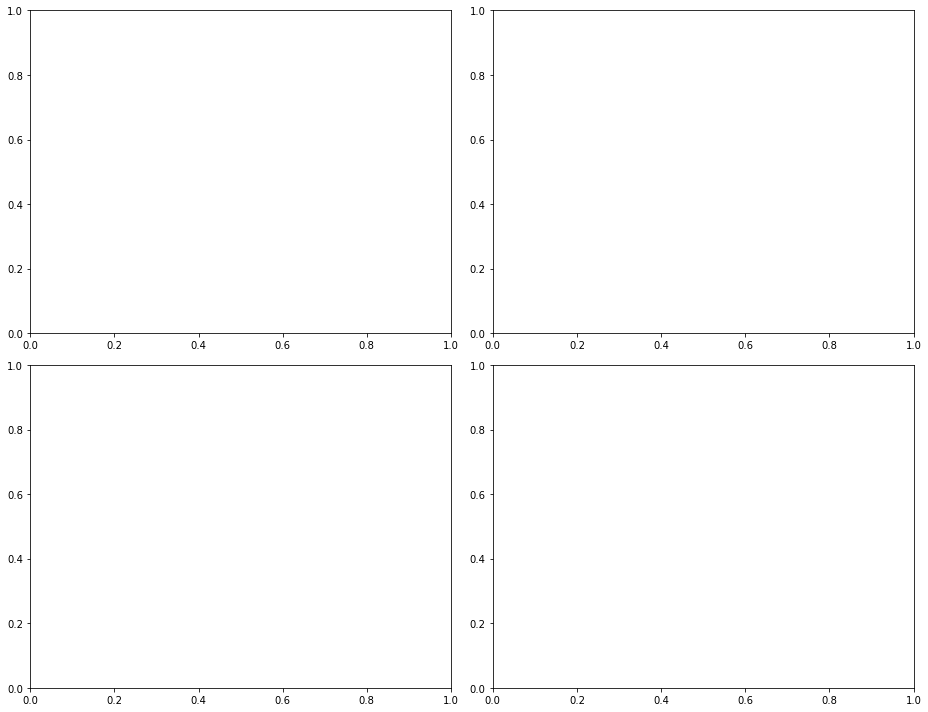

In [4]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

xr.open_dataset(op.join(ddir,'ctrl/vars000.nc')).q.isel(t=0,z=0).plot(ax=axes[0,0])
xr.open_dataset(op.join(ddir,'run50/vars000.nc')).q.isel(t=0,z=0).plot(ax=axes[0,1])
xr.open_dataset(op.join(ddir,'ctrl/vars000.nc')).q.isel(t=150,z=0).plot(ax=axes[1,0])
xr.open_dataset(op.join(ddir,'run50/vars000.nc')).q.isel(t=150,z=0).plot(ax=axes[1,1])

In [24]:
U = .1
T = 5e5    # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 1024   # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

In [6]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
    
#     lap = (psi_padded[...,2:,1:-1] + psi_padded[...,:-2,1:-1] 
#            + psi_padded[...,1:-1,2:] + psi_padded[...,1:-1,:-2] 
#            - 4*psi_padded[...,1:-1,1:-1]
#           ) / Delta**2

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [7]:
ds = xr.open_zarr(op.join(rund, 'ctrl/vars001'))
ds

<xarray.Dataset>
Dimensions:  (XC: 1024, XG: 1024, Xp1: 1026, YC: 1024, YG: 1024, Yp1: 1026, Z: 3, Zp1: 2, time: 312)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XG       (XG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * Xp1      (Xp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YG       (YG) float64 0.0 0.07812 0.1562 0.2344 ... 79.69 79.77 79.84 79.92
  * Yp1      (Yp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
Data variables:
    psi      (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>
    psip1    (time, Zp1, Yp1, Xp1) float64 dask.array<chunksize=(10, 2, 100, 100), meta=np.ndarray>
    ptr0     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>
    ptr1     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>
    ptr2     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>
    ptr3     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 100, 100), meta=np.ndarray>

In [8]:
dtt = 7
ttstart = 45
for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                dsw = xr.open_zarr(op.join(rund, 'run%03d/W001_dN2dt' % i)
                                  ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
                dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'run%03d/W001_dN2dt' % i)
                                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                                ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars001')
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'ctrl/W001_dN2dt')
                                             ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                            ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    dsw.coords['nmemb'] = ('nmemb',range(nmemb+1))
#     ds = ds.chunk({'nmemb':-1})
#     dsw = dsw.chunk({'nmemb':-1})

    dsave = ds.psi.mean('nmemb').compute().to_dataset(name='psib')
    dsave['psip1b'] = ds.psip1.mean('nmemb').compute()
    dsave['wb'] = dsw.w.mean('nmemb').compute()
    dsave = dsave.drop_vars(['drC','drF']).chunk({'time':-1,'YC':128,'XC':128,
                                                  'Yp1':100,'Xp1':100})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'Mean001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    dsw.close()
    ds.close()
    print(tt)

In [6]:
dtt = 7
ttstart = 39
for tt in range(ttstart,int(312/dtt)+1):
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                ds = xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                dsw = xr.open_zarr(op.join(rund, 'run%03d/W001_dN2dt' % i)
                                  ).isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                               ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                               ], 'nmemb')
                dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'run%03d/W001_dN2dt' % i)
                                                 ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                                ], 'nmemb')
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(rund, 'ctrl/vars001')
                                           ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                           ], 'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(rund, 'ctrl/W001_dN2dt')
                                             ).isel(time=slice(tt*dtt,tt*dtt+dtt))
                            ], 'nmemb')

    ds.coords['nmemb'] = ('nmemb',range(nmemb+1))
    dsw.coords['nmemb'] = ('nmemb',range(nmemb+1))
    
    dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" 
                               % (tt*dtt,tt*dtt+len(ds.time)-1))
                      )
    psip = ds.psi - dsb.psib
    psip1p = ds.psip1 - dsb.psip1b
    wp = dsw.w - dsb.wb
    
    dsave = psip.to_dataset(name='psip')
    dsave['psip1p'] = psip1p
    dsave['wp'] = wp
    dsave = dsave.drop_vars(['drC','drF']).chunk({'time':-1,'YC':128,'XC':128,
                                                  'Yp1':100,'Xp1':100})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'Eddy001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(ds.time)-1)), mode='w'
                 )
    dsave.close()
    dsw.close()
    ds.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, Xp1: 1026, YC: 1024, Yp1: 1026, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1      (Xp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Yp1      (Yp1) float64 -0.03906 0.03906 0.1172 0.1953 ... 79.88 79.96 80.04
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 584.0 585.0 586.0 587.0 588.0 589.0 590.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * Zp1      (Zp1) float64 0.06 0.2
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    psip     (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    psip1p   (nmemb, time, Zp1, Yp1, Xp1) float64 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>
    wp       (nmemb, time, Zp1, YC, XC) float64 dask.array<chunksize=(1, 7, 2, 128, 128), meta=np.ndarray>
39
4

In [6]:
psi_padp = ds.psi - psi_padb

dpsib_z = xr.DataArray(-grid.diff(psi_padb.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),'Z').data,
                       dims=['Zp1','XC','YC'], 
                       coords={'Zp1':ds.Zp1.data,
                               'YC':ds.YC.data,'XC':ds.XC.data}
                      )
dpsip_z = xr.DataArray(-grid.diff(psi_padp.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),'Z').data,
                       dims=['nmemb','Zp1','XC','YC'], 
                       coords={'nmemb':ds.nmemb.data,'Zp1':ds.Zp1.data,
                               'YC':ds.YC.data,'XC':ds.XC.data}
                      )

eps = Ekb / (2*Rom*ds.drF.isel(Z=-1))
dEk = Ekb * (ds.drF.isel(Z=-1).values)
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*tt)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*tt) 
           * Frm**2 * ds.drC**-1*aFrN*(2*np.pi*fFr_r**-1)
          )


dpsipadb_z = -grid.diff(psi_padb,'Z')
dpsipadp_z = -grid.diff(psi_padp,'Z')

lapsib = laplacian(psi_padb, Delta=dx, padded=True)
ladpsib_z = laplacian(dpsipadb_z, Delta=dx, padded=True)
lapsip = laplacian(psi_padp, Delta=dx, padded=True)
ladpsip_z = laplacian(dpsipadp_z, Delta=dx, padded=True)


print(psi_padp.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)))
print(lapsip)
print(dpsip_z)
print(ladpsip_z)

<xarray.DataArray 'psi' (nmemb: 101, Z: 3, Yp1: 1024, Xp1: 1024)>
dask.array<getitem, shape=(101, 3, 1024, 1024), dtype=float32, chunksize=(6, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * Xp1      (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1      (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     float32 311.0
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
<xarray.DataArray 'truediv-62c93abdbf6726a527d33ee87d827d4f' (nmemb: 101, Z: 3, Yp1: 1024, Xp1: 1024)>
dask.array<truediv, shape=(101, 3, 1024, 1024), dtype=float32, chunksize=(6, 1, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * Xp1      (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1      (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (

# Ensemble mean

In [7]:
dtt = 7
ttstart = 36

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
    
    if tt == ttstart:
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )
    
    dpsipadb_z = -grid.diff(dsb.psib,'Z')
    dpsipadp_z = -grid.diff(dsp.psip,'Z')
    
    lapsib = laplacian(dsb.psib, Delta=dx, padded=True)
    ladpsib_z = laplacian(dpsipadb_z, Delta=dx, padded=True)
    lapsip = laplacian(dsp.psip, Delta=dx, padded=True)
    ladpsip_z = laplacian(dpsipadp_z, Delta=dx, padded=True)
    
    dsave = lapsib.to_dataset(name='zetab')
    dsave['zetap'] = lapsip
    dsave['lapdpsib_z'] = ladpsib_z
    dsave['lapdpsip_z'] = ladpsip_z
#     dsave.coords['time'] = ('time',dsb.time.data)
    dsave = dsave.chunk({'Z':-1,'Zp1':-1,'Yp1':100,'Xp1':100})
    print(dsave)
    dsave.to_zarr(op.join(rund,'Laplacian001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    
    print(tt)
    
#     yy += 1

<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 563.0 564.0 565.0 566.0 567.0 568.0 569.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36
<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 570.0 571.0 572.0 573.0 574.0 575.0 576.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 577.0 578.0 579.0 580.0 581.0 582.0 583.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 584.0 585.0 586.0 587.0 588.0 589.0 590.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 591.0 592.0 593.0 594.0 595.0 596.0 597.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 598.0 599.0 600.0 601.0 602.0 603.0 604.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41
<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 605.0 606.0 607.0 608.0 609.0 610.0 611.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42
<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 7)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 612.0 613.0 614.0 615.0 616.0 617.0 618.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(7, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(7, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 7, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43
<xarray.Dataset>
Dimensions:     (Xp1: 1024, Yp1: 1024, Z: 3, Zp1: 2, nmemb: 101, time: 4)
Coordinates:
  * Xp1         (Xp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Yp1         (Yp1) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z           (Z) float64 0.03 0.13 0.6
  * time        (time) float32 619.0 620.0 621.0 622.0
  * nmemb       (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
  * Zp1         (Zp1) float64 0.06 0.2
Data variables:
    zetab       (time, Z, Yp1, Xp1) float32 dask.array<chunksize=(4, 3, 100, 100), meta=np.ndarray>
    zetap       (nmemb, time, Z, Yp1, Xp1) float32 dask.array<chunksize=(1, 4, 3, 100, 100), meta=np.ndarray>
    lapdpsib_z  (time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(4, 2, 100, 100), meta=np.ndarray>
    lapdpsip_z  (nmemb, time, Zp1, Yp1, Xp1) float32 dask.array<chunksize=(1, 4, 2, 100, 100), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [7]:
dtt = 7
ttstart = 15

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (308,311)))
    
    if tt == ttstart:
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )

    eps = Ekb / (2*Rom*ds.drF.isel(Z=-1))
    
#########################################     
    lapsib = dsl.zetab
    lapsip = dsl.zetap

    bFrMKE = eps.data*(dsb.psib.isel(Z=-1,Yp1=slice(1,-1),Xp1=slice(1,-1)).data 
                       * xr.DataArray(lapsib.data, dims=['time','Z','YC','XC'], 
                                      coords={'time':dsb.time.data,'Z':dsb.Z.data,
                                              'YC':dsb.YC.data,'XC':dsb.XC.data}
                                     ).isel(Z=-1)
                      )
    bFrEKE = eps.data*(dsp.psip.isel(Z=-1,Yp1=slice(1,-1),Xp1=slice(1,-1)).data 
                       * xr.DataArray(lapsip.data, dims=['nmemb','time','Z','YC','XC'], 
                                      coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                              'Z':dsp.Z.data,
                                              'YC':dsp.YC.data,'XC':dsp.XC.data}
                                     ).isel(Z=-1)
                      ).mean('nmemb')
    sEkMKE = (xr.DataArray(-dsb.psib.isel(Z=0,Yp1=slice(1,-1),Xp1=slice(1,-1)).data,
                           dims=['time','YC','XC'], 
                           coords={'time':dsb.time.data,
                                   'YC':dsb.YC.data,'XC':dsb.XC.data}
                          )
              * xr.DataArray(-tau0 * (np.sin(2*np.pi*np.arange(dx/2,L0,dx)/L0)                                      
                                      * np.sin(np.pi*np.arange(dx/2,L0,dx)/L0)
                                     ) / (Rom*ds.drF.isel(Z=0).data),
                             dims=['YC'], coords={'YC':ds.YC.data}
                            )
             )
#     if tt == ttstart:
#         print(bFrMKE, bFrEKE, sEkMKE)
    dsave = bFrMKE.to_dataset(name='DbMKE')
    dsave['DbEKE'] = bFrEKE
    dsave['FMKE'] = sEkMKE
    dsave = dsave.drop_vars('Z').chunk({'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'VDiss001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    dsl.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 416.0 417.0 418.0 419.0 420.0 421.0 422.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
15
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 423.0 424.0 425.0 426.0 427.0 428.0 429.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time,

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


16
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 430.0 431.0 432.0 433.0 434.0 435.0 436.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
17
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 437.0 438.0 439.0 440.0 441.0 442.0 443.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (ti

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


20
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 458.0 459.0 460.0 461.0 462.0 463.0 464.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


21
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 465.0 466.0 467.0 468.0 469.0 470.0 471.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


22
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 472.0 473.0 474.0 475.0 476.0 477.0 478.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


23
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 479.0 480.0 481.0 482.0 483.0 484.0 485.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


24
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 486.0 487.0 488.0 489.0 490.0 491.0 492.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


25
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 493.0 494.0 495.0 496.0 497.0 498.0 499.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


26


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 500.0 501.0 502.0 503.0 504.0 505.0 506.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

27
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 507.0 508.0 509.0 510.0 511.0 512.0 513.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

28
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 514.0 515.0 516.0 517.0 518.0 519.0 520.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

29
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 521.0 522.0 523.0 524.0 525.0 526.0 527.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

30
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 528.0 529.0 530.0 531.0 532.0 533.0 534.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

31
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 535.0 536.0 537.0 538.0 539.0 540.0 541.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

32
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 542.0 543.0 544.0 545.0 546.0 547.0 548.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

33
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 549.0 550.0 551.0 552.0 553.0 554.0 555.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

34


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 556.0 557.0 558.0 559.0 560.0 561.0 562.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 563.0 564.0 565.0 566.0 567.0 568.0 569.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 570.0 571.0 572.0 573.0 574.0 575.0 576.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 577.0 578.0 579.0 580.0 581.0 582.0 583.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 584.0 585.0 586.0 587.0 588.0 589.0 590.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 591.0 592.0 593.0 594.0 595.0 596.0 597.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 598.0 599.0 600.0 601.0 602.0 603.0 604.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 605.0 606.0 607.0 608.0 609.0 610.0 611.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * time     (time) float32 612.0 613.0 614.0 615.0 616.0 617.0 618.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 4)
Coordinates:
  * time     (time) float32 619.0 620.0 621.0 622.0
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
Data variables:
    DbMKE    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    DbEKE    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    FMKE     (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [7]:
dtt = 7
ttstart = 44

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (308,311)))
    
    if tt == ttstart:
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )
    
    dpsib_z = xr.DataArray(-grid.diff(dsb.psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['time','Zp1','YC','XC'], 
                           coords={'time':dsb.time.data,'Zp1':dsb.Zp1.data,
                                   'YC':dsb.YC.data,'XC':dsb.XC.data}
                          )
    dpsip_z = xr.DataArray(-grid.diff(dsp.psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['nmemb','time','Zp1','YC','XC'], 
                           coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                   'Zp1':dsp.Zp1.data,
                                   'YC':dsp.YC.data,'XC':dsp.XC.data}
                          )

    up = -dsp.psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    vp = dsp.psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

    up1p = -dsp.psip1p.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    vp1p = dsp.psip1p.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

    eps = Ekb / (2*Rom*ds.drF.isel(Z=-1))
    dEk = Ekb * (ds.drF.isel(Z=-1).values)
    Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                       coords={'Zp1':dsb.Zp1}
                      )
    aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                        coords={'Zp1':dsb.Zp1}
                       )
    fFr_r = 62.2
    Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*dsb.time)*aFrN)**-1 * Frm
    gp = Fr**-2 * ds.drC
    gpinv_t = (np.cos(2*np.pi*fFr_r**-1*dsb.time) 
               * Frm**2 * ds.drC**-1*aFrN*(2*np.pi*fFr_r**-1)
              )
    
#########################################    
    dpsipadb_z = -grid.diff(dsb.psib,'Z')
    dpsipadp_z = -grid.diff(dsp.psip,'Z')
    
    lapsip = dsl.zetap
    
    P_K = (dsb.wb * dpsib_z) / Rom
    p_k = (dsp.wp * dpsip_z).mean('nmemb') / Rom
    
    dpsi_zx = xr.DataArray(dpsipadp_z.isel(Yp1=slice(1,-1)).diff('Xp1').data, 
                           dims=vp1p.dims, coords=vp1p.coords) / dx
    dpsi_zy = xr.DataArray(dpsipadp_z.isel(Xp1=slice(1,-1)).diff('Yp1').data, 
                           dims=up1p.dims, coords=up1p.coords) / dx
    P_p = xr.DataArray((    up1p.isel(Yp1=slice(1,None)).data 
                        +   up1p.isel(Yp1=slice(None,-1)).data)
                       * (  dpsi_zx.isel(Xp1=slice(1,None)).data 
                          + dpsi_zx.isel(Xp1=slice(None,-1)).data)
                       + (  vp1p.isel(Xp1=slice(1,None)).data 
                          + vp1p.isel(Xp1=slice(None,-1)).data)
                       * (  dpsi_zy.isel(Yp1=slice(1,None)).data 
                          + dpsi_zy.isel(Yp1=slice(None,-1)).data),
                       dims=dpsip_z.dims, coords=dpsip_z.coords
                      ).mean('nmemb') * .25
    P_p = (dpsib_z * P_p / gp) / Rom**2 
    
    lap_padded = xr.DataArray(pad_bc(lapsip), 
                              dims=['nmemb','time','Z','Yp1','Xp1'],
                              coords={'nmemb':dsp.nmemb.data, 'time':dsp.time.data,
                                      'Z':dsp.Z.data,
                                      'Yp1':dsp.Yp1.data, 'Xp1':dsp.Xp1.data}
                             ).chunk({'nmemb':6,'Yp1':100,'Xp1':100})
    lapx = xr.DataArray(lap_padded.isel(Yp1=slice(1,-1)).diff('Xp1').data, 
                        dims=vp.dims, coords=vp.coords
                       ) / dx
    lapy = xr.DataArray(lap_padded.isel(Xp1=slice(1,-1)).diff('Yp1').data, 
                        dims=up.dims, coords=up.coords
                       ) / dx
    K_k = xr.DataArray((     up.isel(Yp1=slice(1,None)).data 
                        +    up.isel(Yp1=slice(None,-1)).data)
                       * (  lapx.isel(Xp1=slice(1,None)).data 
                          + lapx.isel(Xp1=slice(None,-1)).data)
                       + (  vp.isel(Xp1=slice(1,None)).data 
                          + vp.isel(Xp1=slice(None,-1)).data)
                       * (  lapy.isel(Yp1=slice(1,None)).data 
                          + lapy.isel(Yp1=slice(None,-1)).data),
                       dims=['nmemb','time','Z','YC','XC'], 
                       coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                               'Z':dsp.Z.data,
                               'YC':dsp.YC.data,'XC':dsp.XC.data}
                      ).mean('nmemb') * .25
    K_k = (-dsb.psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data * K_k * ds.drF) 
    
    B_P = -.5*Rom**-2 * (dpsib_z.isel(Zp1=0)**2 * gpinv_t.isel(Zp1=0)) 
    B_p = -.5*Rom**-2 * ((dpsip_z.isel(Zp1=0)**2).mean('nmemb') * gpinv_t.isel(Zp1=0)) 
    
    dsave = P_K.to_dataset(name='P_K')
    dsave['p_k'] = p_k
    dsave['P_p'] = P_p
    dsave['K_k'] = K_k
    dsave['B_P'] = B_P
    dsave['B_p'] = B_p
#     dsave.coords['time'] = ('time',dsb.time.data)
    dsave = dsave.drop_vars(['drC','drF']).chunk({'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'Pis001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    dsl.close()
    
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 4)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
  * time     (time) float32 619.0 620.0 621.0 622.0
  * Z        (Z) float64 0.03 0.13 0.6
Data variables:
    P_K      (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>
    p_k      (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>
    P_p      (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>
    K_k      (time, Z, YC, XC) float64 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    B_P      (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    B_p      (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [7]:
dtt = 7
ttstart = 40

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
        dsl = xr.open_zarr(op.join(rund,"Laplacian001/%03d-%03d" % (308,311)))
    
    if tt == ttstart:
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )
    
    dpsib_z = xr.DataArray(-grid.diff(dsb.psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['time','Zp1','YC','XC'], 
                           coords={'time':dsb.time.data,'Zp1':dsb.Zp1.data,
                                   'YC':dsb.YC.data,'XC':dsb.XC.data}
                          )
    dpsip_z = xr.DataArray(-grid.diff(dsp.psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['nmemb','time','Zp1','YC','XC'], 
                           coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                   'Zp1':dsp.Zp1.data,
                                   'YC':dsp.YC.data,'XC':dsp.XC.data}
                          )

    eps = Ekb / (2*Rom*ds.drF.isel(Z=-1))
    dEk = Ekb * (ds.drF.isel(Z=-1).values)
    Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                       coords={'Zp1':dsb.Zp1}
                      )
    aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                        coords={'Zp1':dsb.Zp1}
                       )
    fFr_r = 62.2
    Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*dsb.time)*aFrN)**-1 * Frm
    gp = Fr**-2 * ds.drC
    
#########################################   
    lapsib = dsl.zetab
    ladpsib_z = dsl.lapdpsib_z
    lapsip = dsl.zetap
    ladpsip_z = dsl.lapdpsip_z
    
    visMKE = (-Re4**-1*(-dsb.psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data) 
              * xr.DataArray(laplacian(laplacian(lapsib, Delta=dx,
                                                 dim=['time','Z','Yp1','Xp1']
                                                ), Delta=dx, 
                                       dim=['time','Z','Yp1','Xp1']
                                      ).data, 
                             dims=['time','Z','YC','XC'], 
                             coords={'time':dsb.time.data,'Z':dsb.Z.data,
                                     'YC':dsb.YC.data,'XC':dsb.XC.data}
                            )
             )
    visMAPE = (-Re4**-1*dpsib_z 
               * xr.DataArray(laplacian(ladpsib_z, Delta=dx, 
                                        dim=['time','Zp1','Yp1','Xp1']
                                       ).data, 
                              dims=dpsib_z.dims, coords=dpsib_z.coords
                             ) / Rom**2 / gp
              )
    visEKE = -Re4**-1*(-dsp.psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
                       * xr.DataArray(laplacian(laplacian(lapsip, Delta=dx,
                                                          dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                          chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                         ), Delta=dx, 
                                                dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                               ).data, 
                                      dims=['nmemb','time','Z','YC','XC'], 
                                      coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                              'Z':dsp.Z.data,
                                              'YC':dsp.YC.data,'XC':dsp.XC.data}
                                     )
                      ).mean('nmemb')
    visEAPE = -Re4**-1*(dpsip_z
                        * xr.DataArray(laplacian(ladpsip_z, Delta=dx,
                                                 dim=['nmemb','time','Zp1','Yp1','Xp1'], 
                                                 chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                ).data,
                                       dims=dpsip_z.dims, coords=dpsip_z.coords
                                      )
                       ).mean('nmemb') / Rom**2 / gp

    dsave = visMKE.to_dataset(name='DhMKE')
    dsave['DhMAPE'] = visMAPE
    dsave['DhEKE'] = visEKE
    dsave['DhEAPE'] = visEAPE
    dsave = dsave.drop_vars('drC').chunk({'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'HDiss001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    dsl.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 591.0 592.0 593.0 594.0 595.0 596.0 597.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
Data variables:
    DhMKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhMAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    DhEKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhEAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 598.0 599.0 600.0 601.0 602.0 603.0 604.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
Data variables:
    DhMKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhMAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    DhEKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhEAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


41
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 605.0 606.0 607.0 608.0 609.0 610.0 611.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
Data variables:
    DhMKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhMAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    DhEKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhEAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


42
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 612.0 613.0 614.0 615.0 616.0 617.0 618.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
Data variables:
    DhMKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhMAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    DhEKE    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    DhEAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


43


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 4)
Coordinates:
  * time     (time) float32 619.0 620.0 621.0 622.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
Data variables:
    DhMKE    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    DhMAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>
    DhEKE    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    DhEAPE   (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [9]:
dpsib_z = -grid.diff(psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),'Z')
dpsip_z = -grid.diff(psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),'Z')
# psi_padb = ds.psi.mean('nmemb')
# psi_padp = ds.psi - psi_padb
ub = -psib.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
up = -psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vb = psib.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
vp = psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
psip1_padb = ds.psip1.mean('nmemb')
psip1_padp = ds.psip1 - psip1_padb
up1b = -psip1_padb.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
up1p = -psip1_padp.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vp1b = psip1_padb.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
vp1p = psip1_padp.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
up

,Array,Chunk
Bytes,19.86 GB,2.38 MB
Shape,"(101, 249, 3, 257, 256)","(6, 10, 1, 99, 100)"
Count,1569818 Tasks,19125 Chunks
Type,float32,numpy.ndarray


In [8]:
# MKE = .25*xr.DataArray((ub**2).isel(Yp1=slice(None,-1)).data + (ub**2).isel(Yp1=slice(1,None)).data 
#                        + (vb**2).isel(Xp1=slice(None,-1)).data + (vb**2).isel(Xp1=slice(None,-1)).data,
#                        dims=ds.p.isel(nmemb=0).dims, coords=ds.p.isel(nmemb=0).coords
#                       )
# EKE = .25*xr.DataArray((up**2).isel(Yp1=slice(None,-1)).data + (up**2).isel(Yp1=slice(1,None)).data 
#                        + (vp**2).isel(Xp1=slice(None,-1)).data + (vp**2).isel(Xp1=slice(None,-1)).data,
#                        dims=ds.p.dims, coords=ds.p.coords
#                       ).mean('nmemb')
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsE = xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')
MKE = dsE.MKE
EKE = dsE.EKE
MAPE = dsE.MAPE
EAPE = dsE.EAPE

In [9]:
HMKE = (MKE*ds.drF).sum(['Z','YC','XC']).compute() * dx**2 
HEKE = (EKE*ds.drF).sum(['Z','YC','XC']).compute() * dx**2 
# print(HMKE, HEKE)
# MAPE = .5/Rom**2/gp * dpsib_z**2
# EAPE = .5/Rom**2/gp * (dpsip_z**2).mean('nmemb')
HMAPE = MAPE.sum(['Zp1','YC','XC']).compute() * dx**2 
HEAPE = EAPE.sum(['Zp1','YC','XC']).compute() * dx**2 
# print(HMAPE, HEAPE)

In [10]:
MKE1s = MKE.isel(time=-47,Z=0).compute()
EKE1s = EKE.isel(time=-47,Z=0).compute()
MKE1w = MKE.isel(time=-15,Z=0).compute()
EKE1w = EKE.isel(time=-15,Z=0).compute()

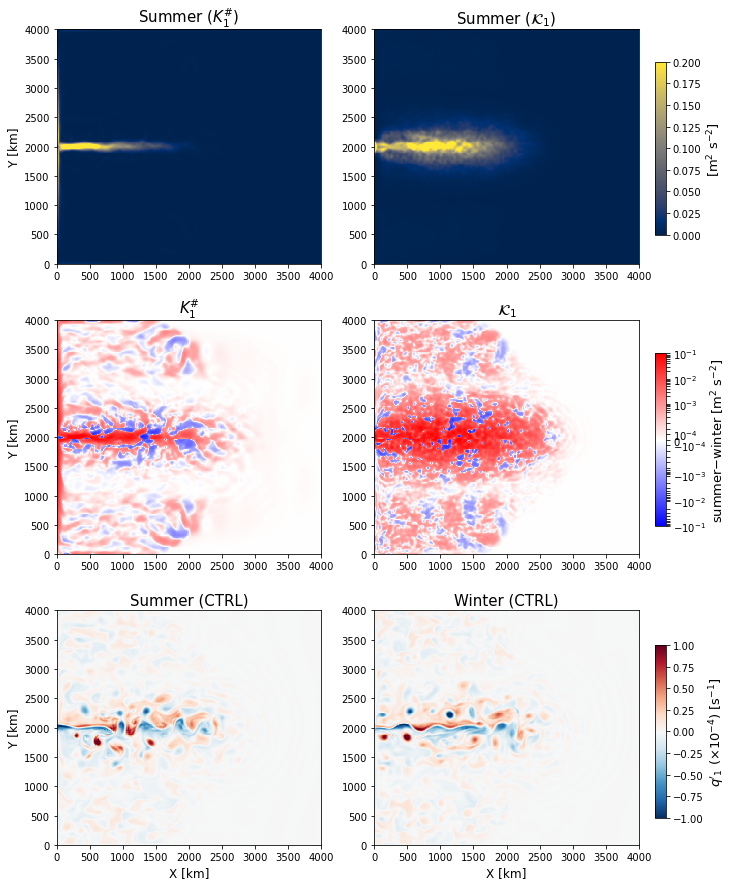

In [11]:
fig, axes = plt.subplots(figsize=(11,20), nrows=4, ncols=2)

im0 = axes[0,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, MKE1s * U**2, 
#                            norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                           vmin=0, vmax=.2,
                           cmap='magma', rasterized=True)
axes[0,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, EKE1s * U**2, 
#                      norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                     vmin=0, vmax=.2,
                     cmap='magma', rasterized=True)
im1 = axes[1,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, MKE1w * U**2, 
#                            norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                           vmin=0, vmax=.2,
                           cmap='magma', rasterized=True)
axes[1,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, EKE1w * U**2, 
#                      norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                     vmin=0, vmax=.2,
                     cmap='magma', rasterized=True)
im2 = axes[2,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, (MKE1s-MKE1w) * U**2, 
                           norm=clr.SymLogNorm(linthresh=5e-4, vmin=-1e-1, vmax=1e-1, base=10), 
                           cmap='bwr', rasterized=True)
axes[2,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, (EKE1s-EKE1w) * U**2, 
                     norm=clr.SymLogNorm(linthresh=5e-4, vmin=-1e-1, vmax=1e-1, base=10), 
                     cmap='bwr', rasterized=True)
im3 = axes[3,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, qp.isel(nmemb=-1,time=-47,Z=0) * U/Rd*1e4,
                           vmin=-1e0, vmax=1e0, cmap='RdBu_r',
                           rasterized=True)
axes[3,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, qp.isel(nmemb=-1,time=-15,Z=0) * U/Rd*1e4,
                     vmin=-1e0, vmax=1e0, cmap='RdBu_r',
                     rasterized=True)

axes[0,0].set_title(r"Summer ($K^\#_1$)", fontsize=15)
axes[0,1].set_title(r"Summer ($\mathcal{K}_1$)", fontsize=15)
axes[1,0].set_title(r"Winter ($K^\#_1$)", fontsize=15)
axes[1,1].set_title(r"Winter ($\mathcal{K}_1$)", fontsize=15)
axes[2,0].set_title(r"$K^\#_1$", fontsize=15)
axes[2,1].set_title(r"$\mathcal{K}_1$", fontsize=15)
axes[3,0].set_title(r"Summer (CTRL)", fontsize=15)
axes[3,1].set_title(r"Winter (CTRL)", fontsize=15)
axes[0,0].set_ylabel(r"Y [km]", fontsize=12)
axes[1,0].set_ylabel(r"Y [km]", fontsize=12)
axes[2,0].set_ylabel(r"Y [km]", fontsize=12)
axes[3,0].set_ylabel(r"Y [km]", fontsize=12)
axes[2,0].set_xlabel(r"X [km]", fontsize=12)
axes[2,1].set_xlabel(r"X [km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.24) 
cax0 = fig.add_axes([0.88, 0.6, 0.014, 0.3])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(r"[m$^2$ s$^{-2}$]", fontsize=13)
cax2 = fig.add_axes([0.88, 0.3, 0.014, 0.15])
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.set_label(r"summer$-$winter [m$^2$ s$^{-2}$]", fontsize=13)
cax3 = fig.add_axes([0.88, 0.05, 0.014, 0.15])
cbar3 = fig.colorbar(im3, cax=cax3)
cbar3.set_label(r"$q'_1\ (\times 10^{-4})$ [s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'../Figs/KE_qp.pdf'))

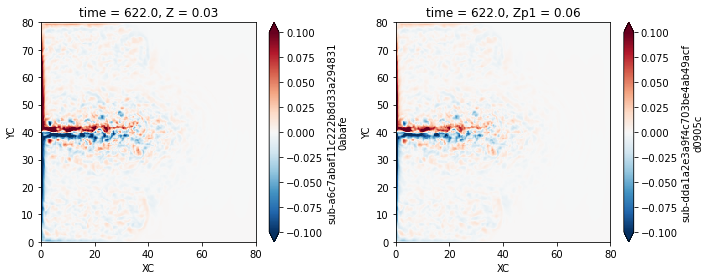

In [7]:
vortb = xr.DataArray(vb.diff('Xp1').data - ub.diff('Yp1').data,
                     dims=['time','Z','YC','XC'], 
                     coords={'time':ds.time.data,'Z':ds.Z.data,
                             'YC':ds.YC.data,'XC':ds.XC.data}
                    ) / dx
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
(vortb*Rom).isel(time=-1,Z=0).plot(ax=ax1, vmax=.1)
(xr.DataArray(vp1b.diff('Xp1').data - up1b.diff('Yp1').data,
              dims=['time','Zp1','YC','XC'], 
              coords={'time':ds.time.data,'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                      'YC':ds.YC.data,'XC':ds.XC.data}
             ) / dx*Rom).isel(time=-1,Zp1=0).plot(ax=ax2, vmax=.1)

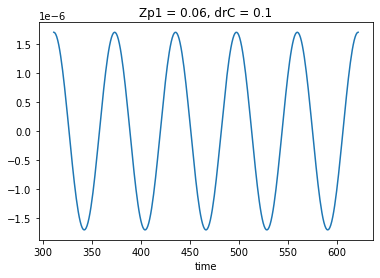

In [10]:
eps = Ekb / (2*Rom*ds.drF.isel(Z=-1))
dEk = Ekb * (ds.drF.isel(Z=-1).values)
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1}
                   )
# Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
#                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
#                   )
# aFrN = xr.DataArray(np.array([0.2,0.]), dims='Zp1', 
#                     coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
#                    )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [21]:
Nz,Ny,Nx = ds.p.isel(nmemb=0).shape

for i in range(101):
    p_bas = np.zeros((Nz,Ny+1,Nx+1))
    p_bas[:,1:,1:] = ds.p.isel(nmemb=i).load().data
    p_bas[:,0,0] = Ny
    p_bas = np.transpose(p_bas, (0,2,1))
    p_bas = p_bas.astype('f4')
    p_bas.tofile(ddir+'lasttimestep/20percent/p_%03d.bas' % i)

In [18]:
plist = []
for i in range(101):
    plist.append(op.join(ddir,'lasttimestep/20percent/p_%03d.bas' % i))
# plist

In [19]:
ws = -tau0 * (np.sin(2*np.pi*np.arange(dx/2,L0,dx)/L0) 
              * np.sin(np.pi*np.arange(dx/2,L0,dx)/L0)
             )
_, ww = np.meshgrid(ds.XC, ws/(Rom*ds.drF[0].values))

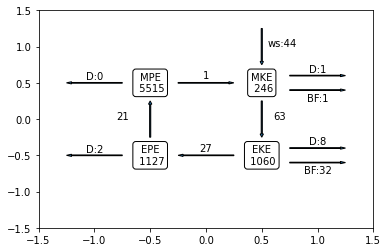

In [31]:
qgutils.energy.draw_lorenz_cycle(qgutils.energy.lorenz_cycle(plist, ds.drF.values, 
                                                             Fr.values**-2, 1/Rom, dx, 
                                                             bf=eps.values, nu4=Re4**-1,
                                                             forcing=ww)
                                )

In [11]:
# dsE = HMKE.to_dataset(name='HMKE')
# dsE['HEKE'] = HEKE
# dsE['HMAPE'] = HMAPE
# dsE['HEAPE'] = HEAPE
# dsE.to_netcdf(op.join(ddir,"Mean-eddy_energies_last4yrs.nc"))
# dsE = xr.open_dataset(op.join(ddir,"Mean-eddy_energies_last4yrs.nc"))
# HMKE = dsE.HMKE
# HEKE = dsE.HEKE
# HMAPE = dsE.HMAPE
# HEAPE = dsE.HEAPE

In [12]:
dpsipadb_z = xr.DataArray(-psi_padb.diff('Z').data, dims=['time','Zp1','Yp1','Xp1'],
                          coords={'time':dsp1.time.data,
                                  'Zp1':dsp1.Zp1.data,'Yp1':dsp1.Yp1.data,'Xp1':dsp1.Xp1.data}
                         )
dpsipadp_z = xr.DataArray(-psi_padp.diff('Z').data, dims=['nmemb','time','Zp1','Yp1','Xp1'],
                          coords={'nmemb':dsp1.nmemb.data,'time':dsp1.time.data,
                                  'Zp1':dsp1.Zp1.data,'Yp1':dsp1.Yp1.data,'Xp1':dsp1.Xp1.data}
                         )
dpsipadp_z

,Array,Chunk
Bytes,13.39 GB,2.40 MB
Shape,"(101, 249, 2, 258, 258)","(6, 10, 1, 100, 100)"
Count,1439768 Tasks,7650 Chunks
Type,float32,numpy.ndarray


In [13]:
lapsib = laplacian(psi_padb, Delta=dx, padded=True)
ladpsib_z = laplacian(dpsipadb_z, Delta=dx, padded=True)
# lapsip = xr.ones_like(psip).load()
# ladpsip_z = xr.ones_like(dpsip_z).load()
# for i in range(nmemb+1):
#     lapsip.isel(nmemb=i)[:] = laplacian(psip.isel(nmemb=i), Delta=dx)
#     ladpsip_z.isel(nmemb=i)[:] = laplacian(dpsip_z.isel(nmemb=i), Delta=dx)
lapsip = laplacian(psi_padp, Delta=dx, padded=True)
ladpsip_z = laplacian(dpsipadp_z, Delta=dx, padded=True)
ladpsip_z

,Array,Chunk
Bytes,13.19 GB,2.30 MB
Shape,"(101, 249, 2, 256, 256)","(6, 10, 1, 98, 98)"
Count,2047518 Tasks,41650 Chunks
Type,float32,numpy.ndarray


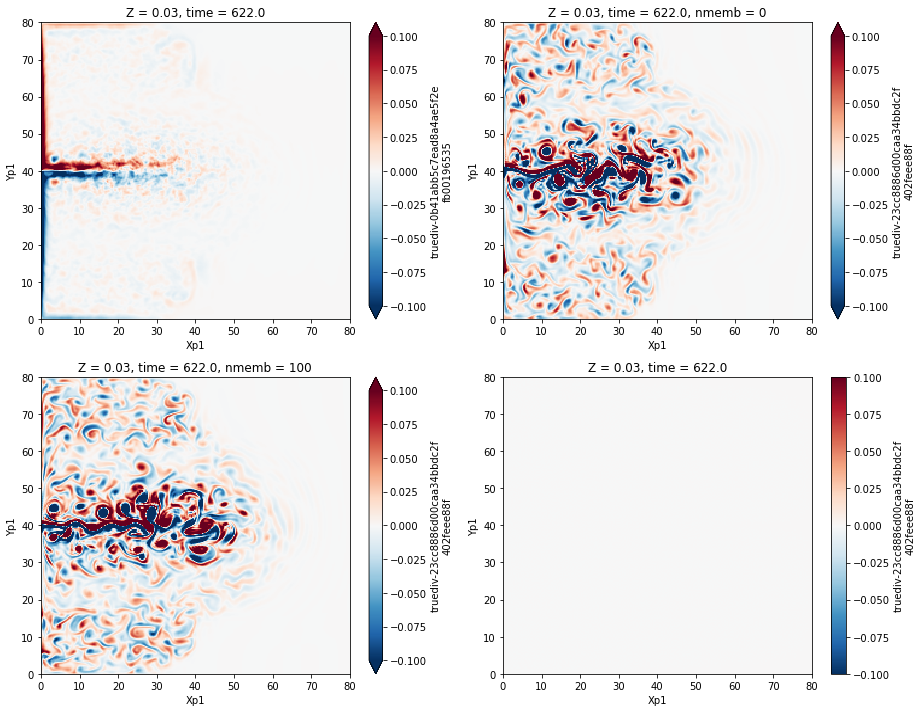

In [10]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(lapsib*Rom).isel(time=-1,Z=0).plot(ax=axes[0,0], vmax=.1)
(lapsip*Rom).isel(nmemb=0,time=-1,Z=0).plot(ax=axes[0,1], vmax=.1)
(lapsip*Rom).isel(nmemb=-1,time=-1,Z=0).plot(ax=axes[1,0], vmax=.1)
(lapsip*Rom).isel(time=-1,Z=0).mean('nmemb').plot(ax=axes[1,1], vmax=.1)

In [12]:
visMKE = (-Re4**-1*(-psib) 
          * xr.DataArray(laplacian(laplacian(lapsib, Delta=dx,
                                             dim=['time','Z','Yp1','Xp1']
                                            ), Delta=dx, 
                                   dim=['time','Z','Yp1','Xp1']
                                  ).data, 
                         dims=psib.dims, coords=psib.coords
                        )
         )
visMAPE = (-Re4**-1*dpsib_z 
           * xr.DataArray(laplacian(ladpsib_z, Delta=dx, 
                                    dim=['time','Zp1','Yp1','Xp1']
                                   ).data, 
                          dims=dpsib_z.dims, coords=dpsib_z.coords
                         ) / Rom**2 / gp
          )

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


In [11]:
# visEKE = xr.ones_like(visMKE).load()
# visEAPE = xr.ones_like(visMAPE).load()
# nm = 40
# for i in range(0,len(ds.time),nm):
#     visEKE.isel(time=slice(i,i+nm))[:] = -Re4**-1*(-psip.isel(time=slice(i,i+nm))
#                                                    * xr.DataArray(laplacian(laplacian(lapsip.isel(time=slice(i,i+nm)), Delta=dx,
#                                                                                       dim=['nmemb','time','Z','Yp1','Xp1'], 
#                                                                                       chunks={'nmemb':6,'Yp1':100,'Xp1':100}
#                                                                                      ), Delta=dx, 
#                                                                             dim=['nmemb','time','Z','Yp1','Xp1'], 
#                                                                             chunks={'nmemb':6,'Yp1':100,'Xp1':100}
#                                                                            ).data, 
#                                                                   dims=psip.isel(time=slice(i,i+nm)).dims, 
#                                                                   coords=psip.isel(time=slice(i,i+nm)).coords
#                                                                  )
#                                                   ).mean('nmemb')
        
#     visEAPE.isel(time=slice(i,i+nm))[:] = -Re4**-1*(dpsip_z.isel(time=slice(i,i+nm))
#                                                     * xr.DataArray(laplacian(ladpsip_z.isel(time=slice(i,i+nm)), Delta=dx,
#                                                                              dim=['nmemb','time','Zp1','Yp1','Xp1'], 
#                                                                              chunks={'nmemb':6,'Yp1':100,'Xp1':100}
#                                                                             ).data,
#                                                                    dims=dpsip_z.isel(time=slice(i,i+nm)).dims, 
#                                                                    coords=dpsip_z.isel(time=slice(i,i+nm)).coords)
#                                                    ).mean('nmemb') / Rom**2 / gp
#     if i % 10 == 0:
#         print(i)
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsD = xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')
visEAPE = dsD.DhEAPE
visMAPE = dsD.DhMAPE
visEKE = dsD.DhEKE
visMKE = dsD.DhMKE

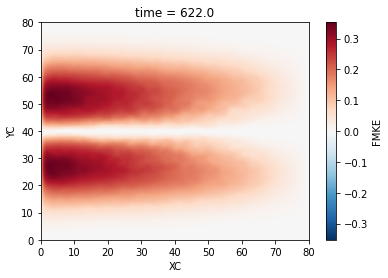

In [12]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsD = xr.open_zarr(op.join(rund,"VDiss001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"VDiss001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"VDiss001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

bFrMKE = dsD.DbMKE
bFrEKE = dsD.DbEKE
sEkMKE = dsD.FMKE
sEkMKE.isel(time=-1).plot()

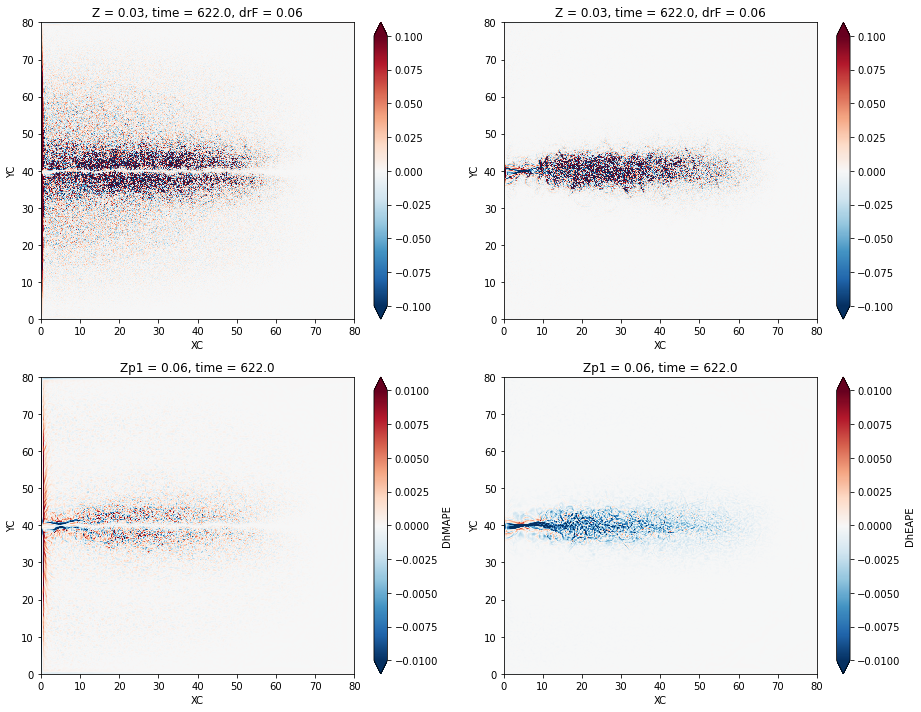

In [13]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(visMKE * ds.drF).isel(time=-1,Z=0).plot(ax=axes[0,0], vmax=.1)
(visEKE * ds.drF).isel(time=-1,Z=0).plot(ax=axes[0,1], vmax=.1)
visMAPE.isel(time=-1,Zp1=0).plot(ax=axes[1,0], vmax=0.01)
visEAPE.isel(time=-1,Zp1=0).plot(ax=axes[1,1], vmax=0.01)

In [12]:
HvisMKE = (visMKE * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
HvisMAPE = visMAPE.sum(['Zp1','YC','XC']).compute() * dx**2
HvisEKE = (visEKE * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
HvisEAPE = visEAPE.sum(['Zp1','YC','XC']).compute() * dx**2

In [12]:
nm = 80
for i in range(0,len(ds.time)+1,nm):
    if i == 0:
        HvisMKE = (-Re4**-1*(-psib.isel(time=slice(i*nm,i*nm+nm))) 
                   * xr.DataArray(laplacian(laplacian(lapsib.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                      dim=['time','Z','Yp1','Xp1']
                                                     ), Delta=dx, 
                                            dim=['time','Z','Yp1','Xp1']
                                           ).data, 
                                  dims=psib.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                  coords=psib.isel(time=slice(i*nm,i*nm+nm)).coords
                                 ) * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
        HvisMAPE = (-Re4**-1*dpsib_z.isel(time=slice(i*nm,i*nm+nm)) 
                    * xr.DataArray(laplacian(ladpsib_z.isel(time=slice(i*nm,i*nm+nm)), Delta=dx, 
                                             dim=['time','Zp1','Yp1','Xp1']
                                            ).data, 
                                   dims=dpsib_z.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                   coords=dpsib_z.isel(time=slice(i*nm,i*nm+nm)).coords
                                  ) / Rom**2 / gp).sum(['Zp1','YC','XC']).compute() * dx**2
    else:
        HvisMKE = xr.concat([HvisMKE,
                             (-Re4**-1*(-psib.isel(time=slice(i*nm,i*nm+nm))) 
                              * xr.DataArray(laplacian(laplacian(lapsib.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                                 dim=['time','Z','Yp1','Xp1']
                                                                ), Delta=dx, dim=['time','Z','Yp1','Xp1']
                                                      ).data,
                                             dims=psib.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                             coords=psib.isel(time=slice(i*nm,i*nm+nm)).coords
                                            ) * ds.drF
                             ).sum(['Z','YC','XC']).compute() * dx**2
                            ], 'time')
        HvisMAPE = xr.concat([HvisMAPE,
                              (-Re4**-1*dpsib_z.isel(time=slice(i*nm,i*nm+nm)) 
                               * xr.DataArray(laplacian(ladpsib_z.isel(time=slice(i*nm,i*nm+nm)), Delta=dx, 
                                                        dim=['time','Zp1','Yp1','Xp1']
                                                       ).data,
                                              dims=dpsib_z.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                              coords=dpsib_z.isel(time=slice(i*nm,i*nm+nm)).coords)
                               / Rom**2 / gp).sum(['Zp1','YC','XC']).compute() * dx**2
                             ], 'time')
        
    if i % 10 == 0:
        print(i)
# visEKE = -Re4**-1*(-psip * (grid.diff(grid.diff(grid.diff(grid.diff(lapsip,'X',boundary='fill', fill_value=0.),
#                                                           'X',boundary='fill', fill_value=0.),
#                                                 'X',boundary='fill', fill_value=0.),
#                                       'X',boundary='fill', fill_value=0.)
#                             + grid.diff(grid.diff(grid.diff(grid.diff(lapsip,'Y',boundary='fill', fill_value=0.),
#                                                             'Y',boundary='fill', fill_value=0.),
#                                                   'Y',boundary='fill', fill_value=0.),
#                                         'Y',boundary='fill', fill_value=0.)
#                            )
#                   ).mean('nmemb') / dx**4
nm = 10
for i in range(0,len(ds.time)+1,nm):
    if i == 0:
        HvisEKE = (-Re4**-1*(-psip.isel(time=slice(i*nm,i*nm+nm)) 
                             * xr.DataArray(laplacian(laplacian(lapsip.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                                dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                                chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                               ), Delta=dx, 
                                                      dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                      chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                     ).data, 
                                            dims=psip.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                            coords=psip.isel(time=slice(i*nm,i*nm+nm)).coords
                                           )
                            ).mean('nmemb') * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
        HvisEAPE = (-Re4**-1*(dpsip_z.isel(time=slice(i*nm,i*nm+nm)) 
                              * xr.DataArray(laplacian(ladpsip_z.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                       dim=['nmemb','time','Zp1','Yp1','Xp1'], 
                                                       chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                      ).data,
                                             dims=dpsip_z.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                             coords=dpsip_z.isel(time=slice(i*nm,i*nm+nm)).coords)
                             ).mean('nmemb') / Rom**2 / gp
                   ).sum(['Zp1','YC','XC']).compute() * dx**2
    else:
        HvisEKE = xr.concat([HvisEKE,
                             (-Re4**-1*(-psip.isel(time=slice(i*nm,i*nm+nm)) 
                                        * xr.DataArray(laplacian(laplacian(lapsip.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                                           dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                                           chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                                          ), Delta=dx, 
                                                                 dim=['nmemb','time','Z','Yp1','Xp1'], 
                                                                 chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                                ).data,
                                                       dims=psip.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                                       coords=psip.isel(time=slice(i*nm,i*nm+nm)).coords)
                                       ).mean('nmemb') * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
                            ], 'time')
        HvisEAPE = xr.concat([HvisEAPE,
                              (-Re4**-1*(dpsip_z.isel(time=slice(i*nm,i*nm+nm)) 
                                         * xr.DataArray(laplacian(ladpsip_z.isel(time=slice(i*nm,i*nm+nm)), Delta=dx,
                                                                  dim=['nmemb','time','Zp1','Yp1','Xp1'], 
                                                                  chunks={'nmemb':6,'Yp1':100,'Xp1':100}
                                                                 ).data,
                                                        dims=dpsip_z.isel(time=slice(i*nm,i*nm+nm)).dims, 
                                                        coords=dpsip_z.isel(time=slice(i*nm,i*nm+nm)).coords)
                                        ).mean('nmemb') / Rom**2 / gp
                              ).sum(['Zp1','YC','XC']).compute() * dx**2
                             ], 'time')
        
    if i % 10 == 0:
        print(i)
# visEKE = -Re4**-1*(-psip * laplacian(laplacian(lapsip, Delta=dx), Delta=dx)).mean('nmemb')
# visMAPE = -Re4**-1*dpsib_z * (grid.diff(grid.diff(grid.diff(grid.diff(dpsib_z,'X',boundary='fill', fill_value=0.),
#                                                             'X',boundary='fill', fill_value=0.),
#                                                   'X',boundary='fill', fill_value=0.),
#                                         'X',boundary='fill', fill_value=0.)
#                               + grid.diff(grid.diff(grid.diff(grid.diff(dpsib_z,'Y',boundary='fill', fill_value=0.),
#                                                               'Y',boundary='fill', fill_value=0.),
#                                                     'Y',boundary='fill', fill_value=0.),
#                                           'Y',boundary='fill', fill_value=0.)
#                              ) / dx**4 / Rom**2 / gp

# visEAPE = -Re4**-1*(dpsip_z * (grid.diff(grid.diff(grid.diff(grid.diff(dpsip_z,'X',boundary='fill', fill_value=0.),
#                                                              'X',boundary='fill', fill_value=0.),
#                                                    'X',boundary='fill', fill_value=0.),
#                                          'X',boundary='fill', fill_value=0.)
#                                + grid.diff(grid.diff(grid.diff(grid.diff(dpsip_z,'Y',boundary='fill', fill_value=0.),
#                                                                'Y',boundary='fill', fill_value=0.),
#                                                      'Y',boundary='fill', fill_value=0.),
#                                            'Y',boundary='fill')
#                               )
#                    ).mean('nmemb') / dx**4 / Rom**2 / gp

# visEAPE = -Re4**-1*(dpsip_z * laplacian(ladpsip_z, Delta=dx)).mean('nmemb') / Rom**2 / gp
# HvisMAPE.coords['time'] = ('time',ds.time.data)
# HvisEAPE.coords['time'] = ('time',ds.time.data)
# HvisEKE.coords['time'] = ('time',ds.time.data)
# HvisMKE.coords['time'] = ('time',ds.time.data)
HvisEAPE

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/dask/array/core.py:4241: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


0
80
160
240
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


<xarray.DataArray (time: 30)>
array([-3.21726645, -3.21028504, -3.2146421 , -3.22635791, -3.23489889,
       -3.24401015, -3.24436532, -3.24894151, -3.26511128, -3.27791961,
       -3.31523984, -3.320711  , -3.313245  , -3.30313899, -3.29979531,
       -3.29868317, -3.29330841, -3.28698145, -3.2847839 , -3.28417885,
       -3.2966378 , -3.31155603, -3.31599588, -3.31919816, -3.32403614,
       -3.33811752, -3.35707836, -3.3553124 , -3.32854775, -3.31765214])
Coordinates:
  * time     (time) float64 374.0 375.0 376.0 377.0 ... 580.0 581.0 582.0 583.0

In [14]:
# dsD = HvisMKE.to_dataset(name='DMKE')
# dsD['DEKE'] = HvisEKE
# dsD['DMAPE'] = HvisMAPE
# dsD['DEAPE'] = HvisEAPE
# dsD.to_netcdf(op.join(ddir,"Mean-eddy_dissip_last4yrs.nc"))
# dsD = xr.open_dataset(op.join(ddir,"Mean-eddy_dissip_last4yrs.nc"))
# HvisMKE = dsD['DMKE']
# HvisEKE = dsD['DEKE']
# HvisMAPE = dsD['DMAPE']
# HvisEAPE = dsD['DEAPE']

In [ ]:
# HvisMKE = (visMKE * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
# HvisEKE = (visEKE * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
# HvisMAPE = visMAPE.sum(['Zp1','YC','XC']).compute() * dx**2
# HvisEAPE = visEAPE.sum(['Zp1','YC','XC']).compute() * dx**2
# print(HvisMKE,HvisEKE,HvisMAPE,HvisEAPE)

In [13]:
# wbb = .5*dEk * lapsib.isel(Z=-1)
# wbp = .5*dEk * lapsip.isel(Z=-1)
# bFrMKE = eps.data*(psib * xr.DataArray(lapsib.data, dims=psib.dims, coords=psib.coords)).isel(Z=-1)
# bFrEKE = eps.data*(psip * xr.DataArray(lapsip.data, dims=psip.dims, coords=psip.coords)).isel(Z=-1).mean('nmemb')

HbFrMKE = (bFrMKE*ds.drF.isel(Z=-1)).sum(['YC','XC']).compute() * dx**2
HbFrEKE = (bFrEKE*ds.drF.isel(Z=-1)).sum(['YC','XC']).compute() * dx**2
# print(HbFrMKE,HbFrEKE)
# bFrMKE.isel(time=0).plot(vmax=5e-3)

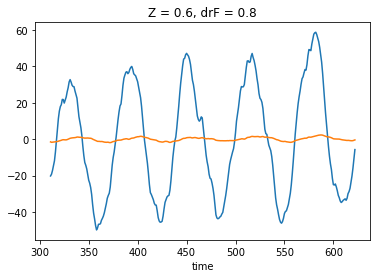

In [20]:
fig, ax = plt.subplots()
(HEKE-HEKE.mean()).plot(ax=ax)
(-HbFrEKE+HbFrEKE.mean()).plot(ax=ax)

In [25]:
print((np.argmax(np.correlate((-HbFrEKE+HbFrEKE.mean()),  
                              (HEKE-HEKE.mean()),
                              mode='full'
                             ))- (ntime - 1.)
      ) * T/86400.)

40.50925925925926


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


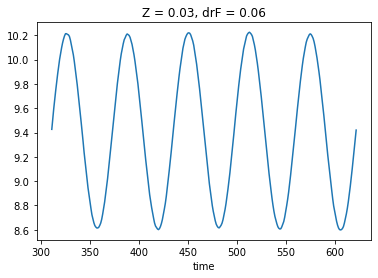

In [14]:
# sEkMKE = (-psib.isel(Z=0))*xr.DataArray(-tau0 * (np.sin(2*np.pi*np.arange(dx/2,L0,dx)/L0) 
#                                                  * np.sin(np.pi*np.arange(dx/2,L0,dx)/L0)
#                                                 ) / (Rom*ds.drF.isel(Z=0).data),
#                                         dims=['YC'], coords={'YC':ds.YC.data})
HsEkMKE = (sEkMKE*ds.drF.isel(Z=0)).sum(['YC','XC']).compute() * dx**2
# HsEkMKE
(HsEkMKE * U**2*H/T*Rd**2*1e-6).plot()

In [15]:
# dsF = HbFrMKE.to_dataset(name='DbMKE')
# dsF['DbEKE'] = HbFrEKE
# dsF['FMAPE'] = HsEkMKE
# dsF.to_netcdf(op.join(ddir,"Mean-eddy_top-bottom_last4yrs.nc"))
# dsF = xr.open_dataset(op.join(ddir,"Mean-eddy_top-bottom_last4yrs.nc"))
# HbFrMKE = dsF['DbMKE']
# HbFrEKE = dsF['DbEKE']
# HsEkMKE = dsF['FMAPE']

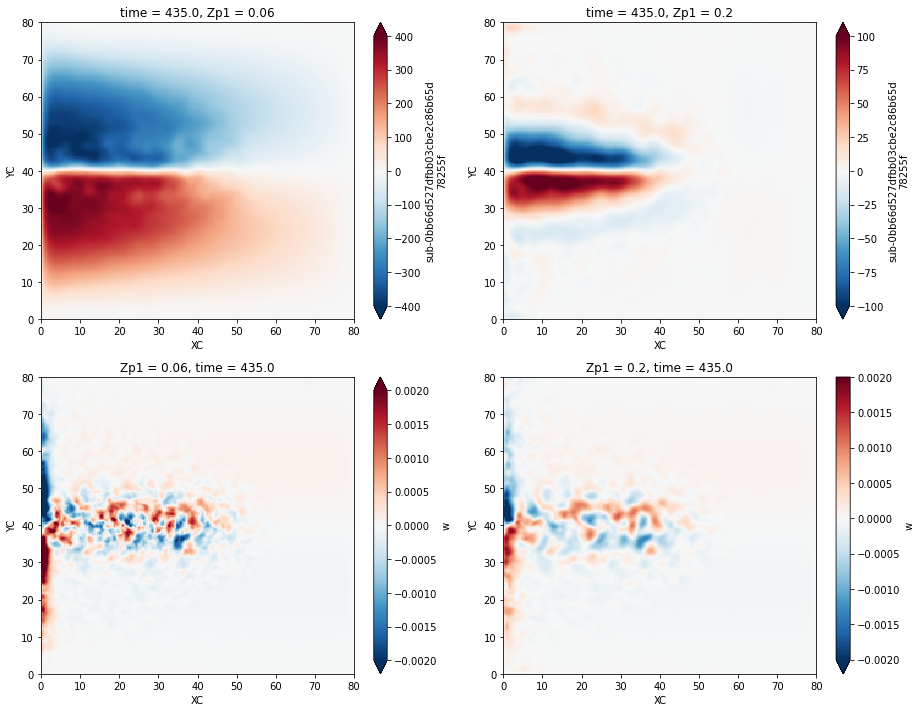

In [21]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(dpsib_z / Rom).isel(time=0,Zp1=0).plot(ax=axes[0,0], vmax=400)
(dpsib_z / Rom).isel(time=0,Zp1=1).plot(ax=axes[0,1], vmax=100)
wb.isel(time=0,Zp1=0).plot(ax=axes[1,0], vmax=0.002)
wb.isel(time=0,Zp1=1).plot(ax=axes[1,1], vmax=0.002)

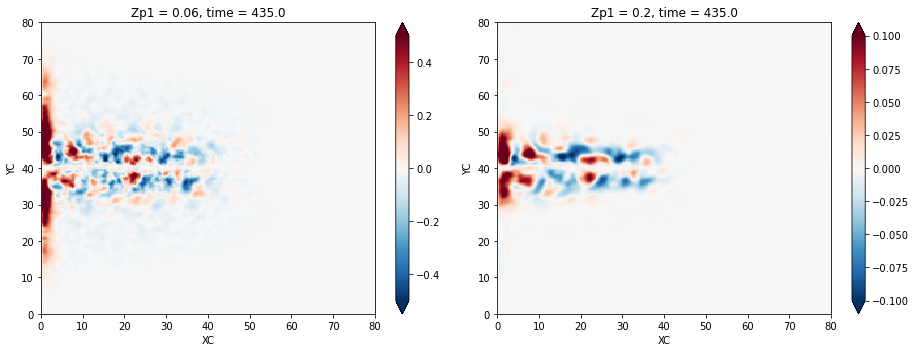

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wb * dpsib_z / Rom).isel(time=0,Zp1=0).plot(ax=ax1, vmax=.5)
(wb * dpsib_z / Rom).isel(time=0,Zp1=1).plot(ax=ax2, vmax=.1)

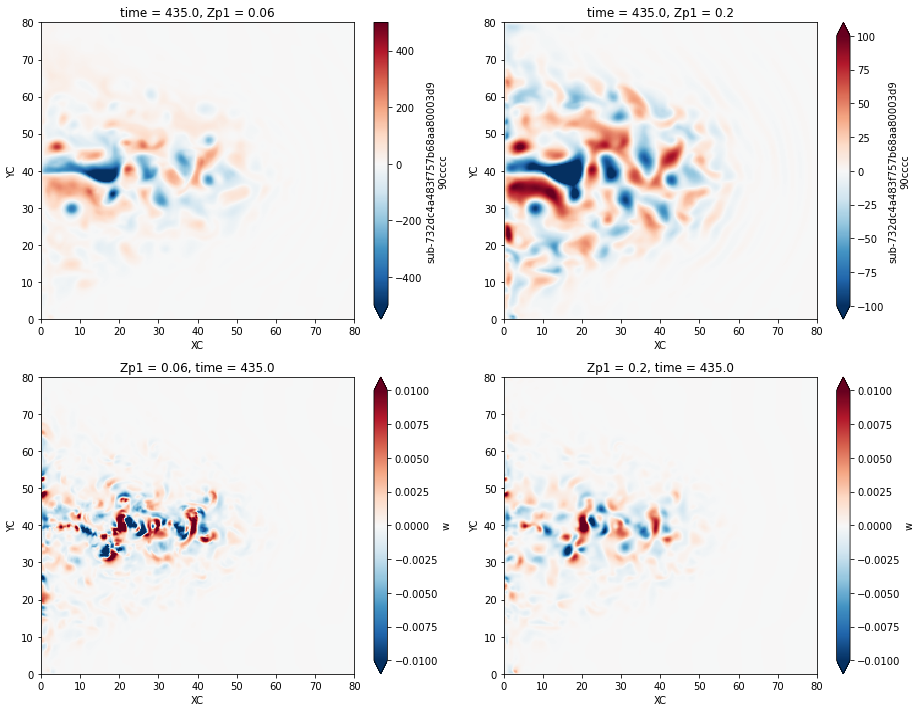

In [19]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=0).plot(ax=axes[0,0], vmax=500)
(dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=1).plot(ax=axes[0,1], vmax=100)
wp.isel(nmemb=-1,time=0,Zp1=0).plot(ax=axes[1,0], vmax=0.01)
wp.isel(nmemb=-1,time=0,Zp1=1).plot(ax=axes[1,1], vmax=0.01)

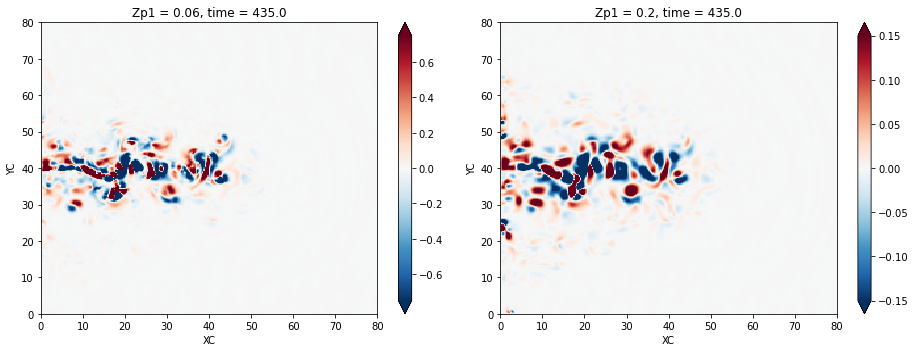

In [12]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wp * dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=0).plot(ax=ax1, vmax=.75)
(wp * dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=1).plot(ax=ax2, vmax=.15)

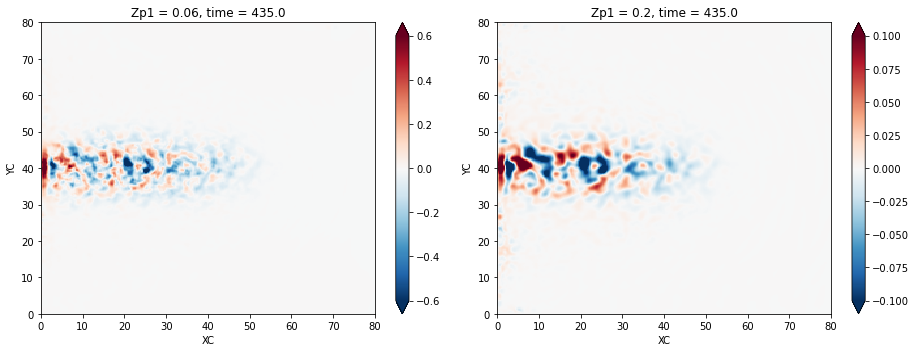

In [14]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wp * dpsip_z / Rom).isel(time=0,Zp1=0).mean('nmemb').plot(ax=ax1, vmax=.6)
(wp * dpsip_z / Rom).isel(time=0,Zp1=1).mean('nmemb').plot(ax=ax2, vmax=.1)

In [15]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsP = xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [16]:
# P_K = (wb * dpsib_z).sum(['Zp1','YC','XC']).compute() * dx**2 / Rom
P_K = dsP.P_K.sum(['Zp1','YC','XC']).compute() * dx**2
# p_k = (wp * dpsip_z).mean('nmemb').sum(['Zp1','YC','XC']).compute() * dx**2 / Rom
p_k = dsP.p_k.sum(['Zp1','YC','XC']).compute() * dx**2

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


In [17]:
# K_k = xr.ones_like(psib).load()

# nm = 40
# for i in range(0,len(ds.time),nm):
#     lap_padded = xr.DataArray(pad_bc(lapsip.isel(time=slice(i,i+nm))), 
#                               dims=['nmemb','time','Z','Yp1','Xp1'],
#                               coords={'nmemb':ds.nmemb.data,'Z':ds.Z.data,
#                                       'Yp1':np.arange(-dx/2,L0+dx,dx),
#                                       'Xp1':np.arange(-dx/2,L0+dx,dx)}
#                              ).chunk({'nmemb':6,'Yp1':100,'Xp1':100})
#     lapx = xr.DataArray(lap_padded.isel(Yp1=slice(1,-1)).diff('Xp1').data, 
#                         dims=vp.dims, coords=vp.isel(time=slice(i,i+nm)).coords
#                        ) / dx
#     lapy = xr.DataArray(lap_padded.isel(Xp1=slice(1,-1)).diff('Yp1').data, 
#                         dims=up.dims, coords=up.isel(time=slice(i,i+nm)).coords
#                        ) / dx

#     K_k.isel(time=slice(i,i+nm))[:] = xr.DataArray((up.isel(time=slice(i,i+nm),Yp1=slice(1,None)).data 
#                                                     + up.isel(time=slice(i,i+nm),Yp1=slice(None,-1)).data)
#                                                    * (lapx.isel(Xp1=slice(1,None)).data 
#                                                       + lapx.isel(Xp1=slice(None,-1)).data)
#                                                    + (vp.isel(time=slice(i,i+nm),Xp1=slice(1,None)).data 
#                                                       + vp.isel(time=slice(i,i+nm),Xp1=slice(None,-1)).data)
#                                                    * (lapy.isel(Yp1=slice(1,None)).data 
#                                                       + lapy.isel(Yp1=slice(None,-1)).data),
#                                                    dims=psip.isel(time=slice(i,i+nm)).dims, 
#                                                    coords=psip.isel(time=slice(i,i+nm)).coords
#                                                   ).mean('nmemb') * .25
#     if i % 10 == 0:
#         print(i)

# K_k = (-psib * K_k * ds.drF).sum(['Z','YC','XC']).compute() * dx**2
K_k = dsP.K_k.sum(['Z','YC','XC']).compute() * dx**2
K_k

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


<xarray.DataArray 'K_k' (time: 312)>
array([27.24375114, 22.00720306, 21.33344232, 19.97722846, 23.90694624,
       30.13691243, 31.98133589, 35.61646628, 32.31482442, 30.96149371,
       25.54063829, 30.83359762, 30.90417194, 21.34759848, 26.75734851,
       35.15500043, 32.12766645, 32.69000782, 31.50806864, 32.9605633 ,
       27.65650036, 29.75331133, 27.80750597, 32.71699374, 31.5116756 ,
       31.60919318, 32.44870816, 28.96699918, 24.04805965, 29.05529765,
       29.61146316, 27.79197526, 26.8273571 , 23.39023941, 21.88878613,
       25.41832673, 25.01790603, 25.50712579, 24.78047754, 27.93255518,
       26.8808457 , 23.39429319, 23.59873398, 21.75037988, 23.94722965,
       22.7677263 , 20.88346943, 24.16354243, 28.02518006, 24.71594364,
       21.28826523, 24.21253978, 25.81016396, 25.11068682, 27.05317444,
       25.00104486, 25.59381762, 25.80364047, 25.20142326, 22.47471165,
       28.08214267, 30.55562897, 30.40695904, 25.33467094, 23.54053698,
       25.94992858, 28.57008003, 30.68695959, 32.23126409, 35.32449397,
       33.73205553, 30.40818233, 29.44201755, 35.69105326, 31.29909379,
       30.97112079, 31.89335767, 31.76081913, 29.35873876, 32.00035751,
       36.01697952, 33.50363289, 34.31269801, 34.68034903, 28.53922951,
       33.17642605, 31.90492199, 30.21480452, 31.58874287, 31.53245143,
       28.90551754, 31.29671307, 32.69325177, 24.9837709 , 25.70111055,
       24.5956805 , 28.12461767, 28.10475934, 25.93064528, 21.78658729,
...
       32.62960375, 31.17301398, 30.61848118, 24.95398149, 27.39239429,
       30.20624797, 29.72216139, 27.56796232, 28.01519494, 28.84871581,
       27.82541604, 26.49498619, 23.62913023, 21.11356885, 20.87550453,
       18.9455018 , 22.1420647 , 20.62647765, 21.51684631, 24.47223516,
       24.09935925, 24.64563726, 24.46958613, 24.98288985, 26.21369681,
       25.09855045, 25.28330876, 27.10504748, 26.03496417, 26.50700841,
       22.6395172 , 26.73771228, 27.12704975, 29.4801795 , 29.89507806,
       32.21616994, 30.2842701 , 30.41007882, 28.03378413, 30.68452041,
       32.72304529, 33.76096214, 31.18207632, 32.73951641, 35.28295098,
       29.35504511, 32.76517002, 34.32891324, 34.59978234, 31.54069201,
       26.29941062, 32.77804484, 38.21810063, 36.48357998, 37.82324328,
       35.33311908, 34.98217985, 30.81364487, 31.69260271, 29.71928406,
       30.35560485, 31.41099346, 31.52385884, 25.82913561, 26.71031145,
       26.23788881, 23.73676878, 25.14425056, 20.99735073, 22.62987424,
       23.73008888, 31.12470122, 25.8790699 , 21.67433881, 25.2760026 ,
       28.71847826, 27.64397634, 24.95417822, 21.69219686, 22.72877062,
       24.55253454, 23.04886883, 21.65069386, 22.88240086, 22.79935154,
       24.70862467, 23.59431834, 22.11241261, 28.11451152, 27.3744627 ,
       26.15842284, 27.96314949, 27.08557477, 28.39058262, 27.13821553,
       28.78529288, 25.63964452])
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0

In [18]:
# dpsi_zx = xr.DataArray(dpsipadp_z.isel(Yp1=slice(1,-1)).diff('Xp1').data, 
#                        dims=vp1p.dims, coords=vp1p.coords) / dx
# dpsi_zy = xr.DataArray(dpsipadp_z.isel(Xp1=slice(1,-1)).diff('Yp1').data, 
#                        dims=up1p.dims, coords=up1p.coords) / dx

# P_p = xr.DataArray((up1p.isel(Yp1=slice(1,None)).data 
#                     + up1p.isel(Yp1=slice(None,-1)).data)
#                    * (dpsi_zx.isel(Xp1=slice(1,None)).data 
#                       + dpsi_zx.isel(Xp1=slice(None,-1)).data)
#                    + (vp1p.isel(Xp1=slice(1,None)).data 
#                       + vp1p.isel(Xp1=slice(None,-1)).data)
#                    * (dpsi_zy.isel(Yp1=slice(1,None)).data 
#                       + dpsi_zy.isel(Yp1=slice(None,-1)).data),
#                    dims=dpsip_z.dims, coords=dpsip_z.coords
#                   ).mean('nmemb') * .25
        

# jac1 = xr.DataArray((up.isel(Z=0,Yp1=slice(1,None)).data 
#                      + up.isel(Z=0,Yp1=slice(None,-1)).data)
#                     * (dpsi_zx.isel(Zp1=0,Xp1=slice(1,None)).data 
#                        + dpsi_zx.isel(Zp1=0,Xp1=slice(None,-1)).data)
#                     + (vp.isel(Z=0,Xp1=slice(1,None)).data 
#                        + vp.isel(Z=0,Xp1=slice(None,-1)).data)
#                     * (dpsi_zy.isel(Zp1=0,Yp1=slice(1,None)).data 
#                        + dpsi_zy.isel(Zp1=0,Yp1=slice(None,-1)).data),
#                     dims=dpsip_z.isel(Zp1=0).dims, coords=dpsip_z.isel(Zp1=0).coords
#                    ).mean('nmemb') * .25
# jac2 = xr.DataArray((up.isel(Z=2,Yp1=slice(1,None)).data 
#                      + up.isel(Z=2,Yp1=slice(None,-1)).data)
#                     * (dpsi_zx.isel(Zp1=1,Xp1=slice(1,None)).data 
#                        + dpsi_zx.isel(Zp1=1,Xp1=slice(None,-1)).data)
#                     + (vp.isel(Z=2,Xp1=slice(1,None)).data 
#                        + vp.isel(Z=2,Xp1=slice(None,-1)).data)
#                     * (dpsi_zy.isel(Zp1=1,Yp1=slice(1,None)).data 
#                        + dpsi_zy.isel(Zp1=1,Yp1=slice(None,-1)).data),
#                     dims=dpsip_z.isel(Zp1=1).dims, coords=dpsip_z.isel(Zp1=1).coords
#                    ).mean('nmemb') * .25
# P_p1 = (dpsib_z.isel(Zp1=0) * jac1 / dx
#         / gp.isel(Zp1=0)).sum(['XC','YC']) / Rom**2
# P_p2 = (dpsib_z.isel(Zp1=1) * jac2 / dx
#         / gp.isel(Zp1=1)).sum(['XC','YC']) / Rom**2
# P_p = xr.concat([P_p1,P_p2], 'Zp1').sum('Zp1').compute() * dx**2


# P_p = (dpsib_z * P_p / gp).sum(['Zp1','XC','YC']).compute() / Rom**2 * dx**2
P_p = dsP.P_p.sum(['Zp1','XC','YC']).compute() * dx**2
P_p

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


<xarray.DataArray 'P_p' (time: 312)>
array([ 5.60875619,  5.61229449,  6.5048025 ,  8.23939553, 10.34193445,
       10.73361271,  9.63569914,  8.14863673,  6.52146622,  4.96154062,
        2.70063139,  1.57639731,  0.75219295,  1.07073617,  5.02257163,
        8.45178251,  9.28944612, 10.62889657, 10.68359358,  9.1383055 ,
        4.35233172,  3.26300897,  4.33555822,  7.40069556,  7.42586276,
        5.05057187,  3.24335367,  1.89937421,  1.77249766,  3.87379532,
        5.24456155,  5.5380678 ,  4.76388917,  4.31421964,  6.34541708,
        8.56295003,  9.59601413,  8.09979647,  5.40067505,  6.22860517,
        6.04344968,  4.96537332,  3.45032335,  1.47262508,  2.35667233,
        3.9857021 ,  5.45400196,  7.53674294,  8.88315775,  7.03401177,
        5.64173251,  4.54286826,  5.39643365,  5.25858733,  5.68996391,
        7.17313671,  7.48219719,  4.92508678,  4.24632439,  5.35228032,
        6.68448505,  8.05810054,  8.80044126,  7.98231913,  5.83143513,
        5.89698937,  5.75391694,  5.87300495,  6.15635674,  5.75982178,
        3.90785447,  1.44273647,  2.87637978,  7.56683743, 10.32807144,
       10.01128676,  6.7355877 ,  4.19663211,  4.88129393,  5.67024234,
        6.45322231,  6.56154675,  4.78326227,  3.04719802,  1.39425848,
        2.90420847,  3.59810102,  3.51797543,  2.92450425,  2.51618981,
        2.96628542,  5.22895998,  4.62794794,  0.24593459,  0.03483938,
        1.44494777,  3.53882488,  4.79272328,  5.07297391,  5.38982535,
...
        5.18652052,  4.44023659,  2.53526559,  1.42899771,  3.30351647,
        5.65257633,  7.12356756,  7.19165767,  8.89147894, 10.81962188,
        9.39480867,  6.50149346,  2.49039894, -0.67057669,  0.10341592,
        2.32181053,  5.06666001,  5.43942501,  6.02392908,  6.88684498,
        5.86998934,  5.69029869,  7.0380604 ,  8.21758351,  7.80315122,
        5.87411059,  4.01176852,  4.85350962,  6.38035492,  7.85499679,
        8.2301967 , 10.29967907, 11.70276713, 12.8906018 , 10.8531896 ,
        9.89405242,  8.1728916 ,  8.28348951,  6.7164534 ,  4.37235867,
        3.81790774,  4.46408108,  1.91766009,  0.38659836,  0.36920409,
        0.56151544,  3.96742387,  7.22535438,  8.27275415,  7.67172324,
        6.28234323,  7.34592685,  9.78423123, 10.12622164,  8.53259171,
        6.34630933,  5.48994734,  4.58445089,  4.9082916 ,  6.07874127,
        4.72707577,  0.86349112, -2.22806183, -3.7509969 , -1.23604051,
       -0.85466952,  0.06400504,  3.75542923,  4.98414193,  5.22774129,
        4.4811739 ,  4.99891176,  5.3216999 ,  6.70332838,  9.79361073,
       11.2383975 ,  9.70849191,  6.27817077,  4.75410759,  5.30515427,
        5.28737622,  5.77132257,  7.1017109 ,  8.46361274,  7.15870348,
        5.85717744,  4.06855779,  3.89107681,  4.0498762 ,  3.07057747,
        3.24681402,  4.21094626,  5.80687237,  7.11382401,  8.49759918,
        9.56407292,  8.10262526])
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0

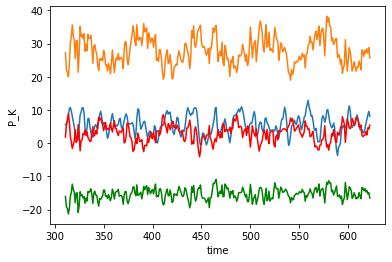

In [21]:
fig, ax = plt.subplots()
P_p.plot(ax=ax)
K_k.plot(ax=ax)
p_k.plot(ax=ax,c='r')
P_K.plot(ax=ax,c='g')

In [19]:
# dsPi = P_K.to_dataset(name='P_K')
# dsPi['p_k'] = p_k
# dsPi['K_k'] = K_k
# dsPi['P_p'] = P_p
# dsPi.to_netcdf(op.join(ddir,"Mean-eddy_energy-fluxes_last4yrs.nc"), mode='w')
# dsPi

<xarray.Dataset>
Dimensions:  (time: 249)
Coordinates:
  * time     (time) float32 374.0 375.0 376.0 377.0 ... 619.0 620.0 621.0 622.0
Data variables:
    P_K      (time) float64 -13.3 -13.56 -12.82 -11.53 ... -15.55 -14.94 -15.62
    p_k      (time) float64 -1.084 -0.3386 -1.38 -3.181 ... 3.187 2.181 2.465
    K_k      (time) float64 28.04 27.9 30.4 32.83 ... 23.43 25.1 26.2 24.97
    P_p      (time) float64 -5.522 -4.116 -5.321 -5.866 ... -8.171 -7.635 -5.803

In [17]:
dsPi = xr.open_dataset(op.join(ddir,"Mean-eddy_energy-fluxes_last4yrs.nc"))
P_K = dsPi.P_K
p_k = dsPi.p_k
K_k = dsPi.K_k
P_p = dsPi.P_p
K_k

<xarray.DataArray 'K_k' (time: 249)>
array([28.036355, 27.896389, 30.399571, ..., 25.095311, 26.196865, 24.970445])
Coordinates:
  * time     (time) float32 374.0 375.0 376.0 377.0 ... 619.0 620.0 621.0 622.0

In [19]:
# B_P = -.5*Rom**-2 * (dpsib_z.isel(Zp1=0)**2 * gpinv_t.isel(Zp1=0)
#                     ).sum(['XC','YC']).compute() * dx**2
B_P = dsP.B_P.sum(['XC','YC']).compute() * dx**2
# B_p = -.5*Rom**-2 * ((dpsip_z.isel(Zp1=0)**2).mean('nmemb') * gpinv_t.isel(Zp1=0)
#                     ).sum(['XC','YC']).compute() * dx**2
B_p = dsP.B_p.sum(['XC','YC']).compute() * dx**2
B_p

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


<xarray.DataArray 'B_p' (time: 312)>
array([-6.94226926, -7.01295177, -6.99181256, -6.89952597, -6.73441343,
       -6.53357423, -6.26954772, -5.91728372, -5.47369452, -4.93762271,
       -4.30263494, -3.60615442, -2.86498978, -2.07953902, -1.27025339,
       -0.45534299,  0.37522098,  1.21200279,  2.04067027,  2.84724347,
        3.60527999,  4.30131042,  4.93187798,  5.51359555,  6.03740607,
        6.47609721,  6.82566931,  7.07001004,  7.19816585,  7.25950676,
        7.26708608,  7.19749325,  7.04408555,  6.81472458,  6.50685253,
        6.15998642,  5.78404857,  5.35424303,  4.88108727,  4.37829859,
        3.85826961,  3.30565037,  2.73487394,  2.15087296,  1.56018847,
        0.97101937,  0.38173131, -0.20527189, -0.79337218, -1.38011019,
       -1.9519581 , -2.51246195, -3.0592264 , -3.59048199, -4.10450288,
       -4.59750469, -5.06442325, -5.48914622, -5.85924399, -6.17723858,
       -6.46541596, -6.72357135, -6.92727032, -7.03164234, -7.04165267,
       -6.96860968, -6.83757095, -6.62547583, -6.34193053, -5.98658747,
       -5.55093052, -5.02090191, -4.40259315, -3.74267298, -3.03189932,
       -2.27400235, -1.47036932, -0.63540414,  0.21241453,  1.06156534,
        1.90615662,  2.73200236,  3.52384814,  4.26173675,  4.92778873,
        5.52292396,  6.04775776,  6.48948736,  6.83838273,  7.11048573,
        7.28529637,  7.37994657,  7.41471379,  7.34214652,  7.1607465 ,
        6.91626598,  6.63304469,  6.29918374,  5.9189206 ,  5.47987054,
...
        7.33598825,  7.38610618,  7.35319714,  7.2225995 ,  7.01821509,
        6.76699109,  6.47822781,  6.12475117,  5.72529923,  5.29375281,
        4.82814727,  4.31144959,  3.75195145,  3.16178188,  2.55610688,
        1.94814459,  1.34603682,  0.74665596,  0.14890526, -0.44613024,
       -1.03956027, -1.62577023, -2.20337877, -2.77304609, -3.32829421,
       -3.86503306, -4.37229042, -4.85684127, -5.31344846, -5.74207289,
       -6.11456912, -6.44331775, -6.73592698, -6.98402508, -7.16649569,
       -7.26371713, -7.28955021, -7.22457841, -7.05998816, -6.80109274,
       -6.46539601, -6.04650686, -5.54490047, -4.95531831, -4.29407979,
       -3.57474411, -2.80507127, -2.00116693, -1.16523444, -0.30472648,
        0.56559987,  1.42828619,  2.28684577,  3.12578504,  3.93572809,
        4.69196847,  5.37294627,  5.97025125,  6.48338094,  6.90957567,
        7.24970414,  7.48803919,  7.6280769 ,  7.64402996,  7.56387044,
        7.43157202,  7.21158092,  6.93465088,  6.61217548,  6.22207537,
        5.79884488,  5.35783539,  4.88910502,  4.36707467,  3.82397406,
        3.27745601,  2.71193412,  2.11761971,  1.50554323,  0.88902284,
        0.27554016, -0.33561828, -0.94184647, -1.54145522, -2.13071044,
       -2.70718916, -3.26653125, -3.79560122, -4.30686093, -4.79882075,
       -5.25161613, -5.66884387, -6.04862   , -6.38809275, -6.68159299,
       -6.91174044, -7.08058866])
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0

In [17]:
Efactor = H*U**2 * Rd**2 * 1e-6
Pifactor = H*U**3 * Rd * 1e-6   # H*U*Rd/Rd*U/(Rd**2)*U*Rd * Rd**2
Efactor

125000.00000000001

In [26]:
print(HvisMKE)
print(HvisEKE)

<xarray.DataArray (time: 312)>
array([-10.12567551,  -0.80614634,  -0.80599477,  -0.80670391,
        -0.80756128,  -0.80660504,  -0.80486477,  -0.80997018,
        -0.8063543 ,  -0.8093071 ,  -0.81313226,  -0.81346912,
        -0.81715525,  -0.82014082,  -0.82324773,  -0.82134206,
        -0.82073194,  -0.82197727,  -0.82501371,  -0.8212156 ,
        -0.82063904,  -0.82035458,  -0.82136896,  -0.82056746,
        -0.82595938,  -0.82911535,  -0.82895107,  -0.82391388,
        -0.82516175,  -0.826046  ,  -0.82836113,  -0.83247537,
        -0.83589831,  -0.83562871,  -0.83124507,  -0.82617052,
        -0.82477461,  -0.82129183,  -0.82022338,  -0.82309638,
        -0.82499336,  -0.83117476,  -0.83162937,  -0.83559804,
        -0.83479665,  -0.83082893,  -0.8372736 ,  -0.84249158,
        -0.83793368,  -0.83618974,  -0.84122389,  -0.84597297,
        -0.84943407,  -0.85491169,  -0.85689829,  -0.85519735,
        -0.85561003,  -0.85960431,  -0.86219127,  -0.8677029 ,
        -0.87738093,  -0

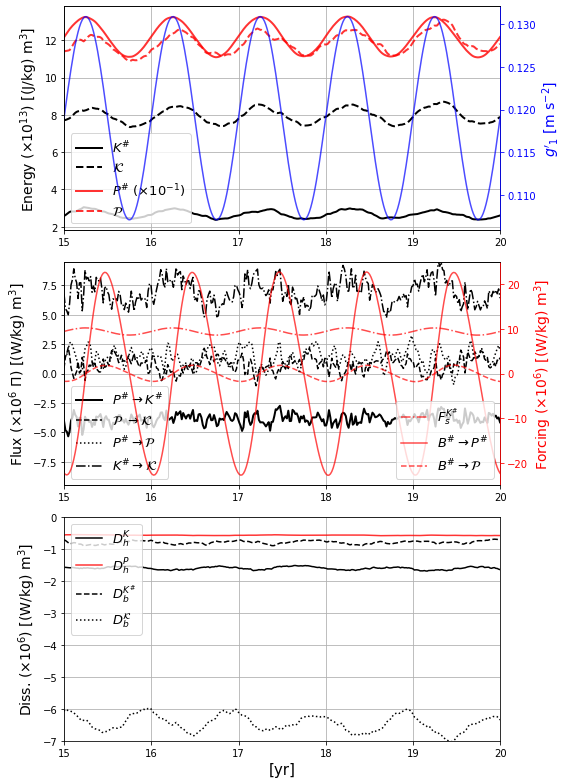

In [32]:
fig, (ax1,ax3,ax5) = plt.subplots(figsize=(8,11), nrows=3, ncols=1)
fig.set_tight_layout(True)
ax2 = ax1.twinx()
ax4 = ax3.twinx()

# ax1.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
#         lw=2)
# ax3.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
#         lw=2)

ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), HMKE * U**2*H*Rd**2*1e-13, 'k', lw=2,
         label=r"$K^\#$")
ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), HEKE * U**2*H*Rd**2*1e-13, 'k--', lw=2,
         label=r"$\mathcal{K}$")
ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), HMAPE*.1 * U**2*H*Rd**2*1e-13, 
         'r', lw=2, alpha=.8,
         label=r"$P^\#\ (\times 10^{-1})$")
ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), HEAPE * U**2*H*Rd**2*1e-13, 
         'r--', lw=2, alpha=.8,
         label=r"$\mathcal{P}$")

ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), P_K * U**2*H/T*Rd**2*1e-6, 'k', lw=2,
         label=r"$P^\# \rightarrow K^\#$")
ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), p_k * U**2*H/T*Rd**2*1e-6, 'k--', 
         label=r"$\mathcal{P}\ \rightarrow \mathcal{K}$")
ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), P_p * U**2*H/T*Rd**2*1e-6, 'k:',
         label=r"$P^\# \rightarrow \mathcal{P}$")
ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), K_k * U**2*H/T*Rd**2*1e-6, 'k-.', 
         label=r"$K^\# \rightarrow \mathcal{K}$")

ax5.plot((ds.time[1:]+ds.time[-1])*T/(diny*86400), (HvisMKE+HvisEKE)[1:] * U**2*H/T*Rd**2*1e-6, 
         c='k',
         label=r"$D^{K}_h$")
# ax5.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HvisEKE * U**2*H/T*Rd**2*1e-6, c='k', ls='--', 
#         label=r"$D^\mathcal{K}_h$")
ax5.plot((ds.time+ds.time[-1])*T/(diny*86400), (HvisMAPE+HvisEAPE) * U**2*H/T*Rd**2*1e-6, 
         c='r', alpha=.8,
         label=r"$D^{P}_h$")
# ax5.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HvisEAPE * U**2*H/T*Rd**2*1e-6, c='r', ls='--', alpha=.8, 
#         label=r"$D^\mathcal{P}_h$")

ax5.plot((ds.time+ds.time[-1])*T/(diny*86400), HbFrMKE * U**2*H/T*Rd**2*1e-6, 'k--', 
         label=r"$D^{K^\#}_b$")
ax5.plot((ds.time+ds.time[-1])*T/(diny*86400), HbFrEKE * U**2*H/T*Rd**2*1e-6, 'k:', 
         label=r"$D^\mathcal{K}_b$")

ax4.plot((ds.time+ds.time[-1])*T/(diny*86400), HsEkMKE * U**2*H/T*Rd**2*1e-6, 
         'r-.', alpha=.7,
         label=r"$F^{K^\#}_s$")
ax4.plot((ds.time+ds.time[-1])*T/(diny*86400), B_P * U**2*H/T*Rd**2*1e-6, 
         c='r', alpha=.7,
         label=r"$B^\# \rightarrow P^\#$")
ax4.plot((ds.time+ds.time[-1])*T/(diny*86400), B_p * U**2*H/T*Rd**2*1e-6, 
         c='r', ls='--', alpha=.7,
         label=r"$B^\# \rightarrow \mathcal{P}$")

ax2.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         gp.isel(Zp1=0) * U**2/(ds.drC.isel(Zp1=0)*H), 
         'b', alpha=.7, zorder=0)

# ax2.set_zorder(-1)
ax1.set_xlim([15.,20.])
# ax1.set_ylim([100.,900.])
ax1.legend(fontsize=13, loc='lower left').set_zorder(3)
ax1.grid(True)
ax1.set_ylabel(r"Energy ($\times 10^{13}$) [(J/kg) m$^3$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax4.spines['right'].set_color('r')
ax4.tick_params(axis='y', colors='r')
ax4.set_ylabel(r"Forcing ($\times 10^{6}$) [(W/kg) m$^3$]", fontsize=14, c='r')
ax3.set_xlim([15.,20.])
ax3.set_ylim([-9.5,9.5])
ax3.legend(fontsize=13, loc='lower left')
ax4.legend(fontsize=13, loc='lower right')
ax3.set_ylabel(r"Flux ($\times 10^{6}\ \Pi$) [(W/kg) m$^3$]", fontsize=14)
ax5.set_xlabel(r"[yr]", fontsize=15)
ax3.grid(True)
ax5.set_xlim([15.,20.])
ax5.set_ylim([-7.,0.])
ax5.legend(fontsize=13, loc='upper left')
ax5.set_ylabel(r"Diss. ($\times 10^6$) [(W/kg) m$^3$]", fontsize=14)
ax5.grid(True)

plt.savefig(op.join(rund,'Figs/Pis_total.pdf'))

In [24]:
times = np.linspace(0,311,310)+311
P_Kintp = P_K.interp(time=times)
p_kintp = p_k.interp(time=times)
K_kintp = K_k.interp(time=times)
P_pintp = P_p.interp(time=times)
gpintp = gp.interp(time=times)
# dsiny = np.concatenate((np.concatenate((np.array([61]),np.tile(np.arange(62),5))),np.array([0])))
dsiny = np.tile(np.arange(62),5)
P_Kintp.coords['diny'] = ('time',dsiny)
p_kintp.coords['diny'] = ('time',dsiny)
K_kintp.coords['diny'] = ('time',dsiny)
P_pintp.coords['diny'] = ('time',dsiny)
K_kintp

<xarray.DataArray 'K_k' (time: 310)>
array([27.24375114, 22.00284215, 21.31588615, 20.05353366, 24.06823987,
       30.19660251, 32.12250601, 35.46687733, 32.24474904, 30.64571573,
       25.88322465, 30.83862233, 30.16191381, 21.8027878 , 27.51830079,
       34.86108451, 32.18590245, 32.55995626, 31.67729132, 32.30828372,
       27.9279322 , 29.48883293, 28.50659161, 32.53756127, 31.52682396,
       31.74503703, 31.8627895 , 28.10737868, 24.95552025, 29.15969117,
       29.25816454, 27.59842728, 26.11546217, 23.06954065, 22.66551351,
       25.32761654, 25.13189898, 25.33310647, 25.55574583, 27.66707511,
       25.97817838, 23.44854608, 23.09626879, 22.36180085, 23.61131931,
       22.21891362, 21.86006074, 25.33828009, 26.99706777, 23.62884822,
       22.2346324 , 24.73991087, 25.57474123, 25.77704179, 26.33592527,
       25.21206429, 25.66986992, 25.58146325, 24.17780337, 24.61606072,
       29.04271987, 30.49693081, 28.37147773, 24.60308233, 24.53860211,
       27.05225767, 29.47437809, 31.35665799, 33.59268566, 34.61330787,
       32.22609356, 29.96418428, 32.35418953, 33.61588795, 31.1420064 ,
       31.41880859, 31.82816072, 30.56366581, 30.69237153, 34.05416423,
       34.71557026, 33.92780296, 34.50782671, 31.38123628, 31.06042375,
       32.47689307, 30.96414462, 30.98847854, 31.55668043, 30.01920149,
       30.29844698, 32.11926985, 28.10249294, 25.41556758, 25.02855117,
       26.76557714, 28.11227851, 26.73978158, 23.30205186, 20.17743004,
...
       27.72858346, 28.88873615, 32.73526519, 33.98171705, 32.0686517 ,
       30.95586683, 28.36368033, 25.94039443, 28.54889726, 30.00415357,
       28.80889253, 27.7604605 , 28.37935454, 28.3950198 , 27.22693789,
       25.18726551, 22.46497075, 21.00185582, 19.9573479 , 20.4868865 ,
       21.40143802, 21.0673398 , 22.99932291, 24.28278041, 24.38045376,
       24.55390835, 24.740358  , 25.64011687, 25.61101253, 25.19959949,
       26.29145543, 26.50593935, 26.30230314, 24.29164937, 25.01355254,
       26.9657708 , 28.52065087, 29.72858155, 31.29975179, 31.03452247,
       30.36203536, 28.92585592, 29.70657887, 31.98416248, 33.39147718,
       32.08343447, 32.20524894, 34.42690828, 31.31182957, 31.66156973,
       33.83296879, 34.51562884, 32.47128907, 27.85992158, 30.891064  ,
       36.66882908, 36.96632683, 37.45906296, 35.99392874, 35.07303791,
       31.86589642, 31.47641891, 30.19185875, 30.20733593, 31.17190866,
       31.49902116, 27.04548426, 26.52780254, 26.33267911, 24.22242316,
       24.88006304, 21.74889245, 22.34457887, 23.54493949, 29.92816201,
       26.69392525, 22.30028584, 24.76314432, 28.25056895, 27.78307044,
       25.28496246, 22.07223353, 22.61471396, 24.36366578, 23.19485579,
       21.77738932, 22.77876208, 22.80580197, 24.57268936, 23.66644173,
       22.19873722, 27.80372323, 27.40799242, 26.20564769, 27.9047441 ,
       27.10829515, 28.36524266, 27.15442741, 28.77463218, 25.63964452])
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
    diny     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60 61

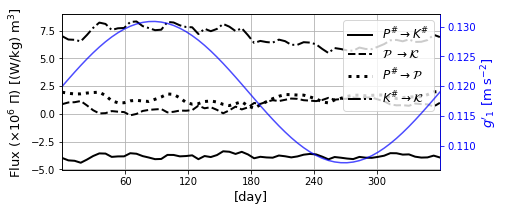

In [25]:
fig, ax1 = plt.subplots(figsize=(7,3), nrows=1, ncols=1)
fig.set_tight_layout(True)
ax2 = ax1.twinx()
# ax4 = ax3.twinx()


ax1.plot(np.linspace(0,360,62), P_Kintp.groupby('diny').mean('time') * U**2*H/T*Rd**2*1e-6, 'k', lw=2,
         label=r"$P^\# \rightarrow K^\#$")
ax1.plot(np.linspace(0,360,62), p_kintp.groupby('diny').mean('time') * U**2*H/T*Rd**2*1e-6, 'k--', lw=2,
         label=r"$\mathcal{P}\ \rightarrow \mathcal{K}$")
ax1.plot(np.linspace(0,360,62), P_pintp.groupby('diny').mean('time') * U**2*H/T*Rd**2*1e-6, 'k:', lw=3,
         label=r"$P^\# \rightarrow \mathcal{P}$")
ax1.plot(np.linspace(0,360,62), K_kintp.groupby('diny').mean('time') * U**2*H/T*Rd**2*1e-6, 'k-.', lw=2,
         label=r"$K^\# \rightarrow \mathcal{K}$")


ax2.plot(np.linspace(0,360,62), 
         gpintp.isel(time=slice(-62,None),Zp1=0) * U**2/(ds.drC.isel(Zp1=0)*H), 'b', alpha=.7)
# ax4.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), gp.isel(Zp1=0), 'b', alpha=.7)

ax1.set_xlim([0,360])
ax1.set_xticks([60,120,180,240,300])
# ax1.set_ylim([100.,900.])
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True)
ax1.set_xlabel(r"[day]", fontsize=13)
ax1.set_ylabel(r"Flux ($\times 10^{6}\ \Pi$) [(W/kg) m$^3$]", fontsize=13)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=13, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

# ax3.set_xlim([15.,20.])
# ax3.set_ylim([-3.,3.])
# ax3.legend(fontsize=13, loc='lower left')
# ax3.grid(True)
# ax3.set_ylabel(r"Energy flux ($\Pi$)", fontsize=15)
# ax4.set_ylabel(r"$g'_1$", fontsize=14, c='b')
# ax4.spines['right'].set_color('b')
# ax4.tick_params(axis='y', colors='b')

plt.savefig(op.join(rund,'Figs/fluxPis_clim.pdf'))

In [21]:
winter = np.array([-14,-15,-16,-17,
                   -76,-77,-78,-79
                   -139,-140,-141,-142,
                   106,107,108,109,
                   44,45,46,47
                  ])
summer = np.array([-45,-46,-47,-48,
                   -107,-108,-109,-110,
                   139,140,141,142,
                   76,77,78,79,
                   14,15,16,17
                  ])
# for i in range(2):
#     winter = np.append(winter,np.array([-14,-15,-16])-(i+1)*60)
#     summer = np.append(summer,np.array([-44,-45,-46])-(i+1)*60)
summer

array([ -45,  -46,  -47,  -48, -107, -108, -109, -110,  139,  140,  141,
        142,   76,   77,   78,   79,   14,   15,   16,   17])

In [24]:
HMKEw = HMKE.isel(time=winter).mean('time')
HEKEw = HEKE.isel(time=winter).mean('time')
HMAPEw = HMAPE.isel(time=winter).mean('time')
HEAPEw = HEAPE.isel(time=winter).mean('time')

HMKEs = HMKE.isel(time=summer).mean('time')
HEKEs = HEKE.isel(time=summer).mean('time')
HMAPEs = HMAPE.isel(time=summer).mean('time')
HEAPEs = HEAPE.isel(time=summer).mean('time')

In [25]:
P_Kw = P_K.isel(time=winter).mean('time')
p_kw = p_k.isel(time=winter).mean('time')
K_kw = K_k.isel(time=winter).mean('time')
P_pw = P_p.isel(time=winter).mean('time')

P_Ks = P_K.isel(time=summer).mean('time')
p_ks = p_k.isel(time=summer).mean('time')
K_ks = K_k.isel(time=summer).mean('time')
P_ps = P_p.isel(time=summer).mean('time')

In [26]:
HvisMKEw = HvisMKE.isel(time=winter).mean('time')
HvisEKEw = HvisEKE.isel(time=winter).mean('time')
HvisMAPEw = HvisMAPE.isel(time=winter).mean('time')
HvisEAPEw = HvisEAPE.isel(time=winter).mean('time')

HvisMKEs = HvisMKE.isel(time=summer).mean('time')
HvisEKEs = HvisEKE.isel(time=summer).mean('time')
HvisMAPEs = HvisMAPE.isel(time=summer).mean('time')
HvisEAPEs = HvisEAPE.isel(time=summer).mean('time')

In [22]:
B_Pw = B_P.isel(time=winter).mean('time')
B_pw = B_p.isel(time=winter).mean('time')
HsEkMKEw = HsEkMKE.isel(time=winter).mean('time')
HbFrMKEw = HbFrMKE.isel(time=winter).mean('time')
HbFrEKEw = HbFrEKE.isel(time=winter).mean('time')

B_Ps = B_P.isel(time=summer).mean('time')
B_ps = B_p.isel(time=summer).mean('time')
HsEkMKEs = HsEkMKE.isel(time=summer).mean('time')
HbFrMKEs = HbFrMKE.isel(time=summer).mean('time')
HbFrEKEs = HbFrEKE.isel(time=summer).mean('time')

In [31]:
print(np.array([P_Kw,p_kw,K_kw,P_pw]) * U**2*H*Rd**2/T*1e-6)
print(np.array([P_Ks,p_ks,K_ks,P_ps]) * U**2*H*Rd**2/T*1e-6)

[-3.95992679  1.30402888  5.91739511  1.51041382]
[-3.96416857  0.34247965  7.77013455  1.46198098]


In [27]:
print(np.array([HMKEw,HEKEw,HMAPEw,HEAPEw]) * U**2*H*Rd**2*1e-13)
print(np.array([HvisMKEw,HvisEKEw,HvisMAPEw,HvisEAPEw]) * U**2*H*Rd**2/T*1e-6)
print(np.array([B_Pw,B_pw,HsEkMKEw,HbFrMKEw,HbFrEKEw]) * U**2*H*Rd**2/T*1e-6)

[  2.4448851    7.4922321  111.70069749  11.25793658]
[-0.20922659 -1.34134992 -0.08927199 -0.48101645]
[ 1.21590136  0.09957712  8.65492819 -0.76021546 -6.3250713 ]


In [28]:
print(np.array([HMKEs,HEKEs,HMAPEs,HEAPEs]) * U**2*H*Rd**2*1e-13)
print(np.array([HvisMKEs,HvisEKEs,HvisMAPEs,HvisEAPEs]) * U**2*H*Rd**2/T*1e-6)
print(np.array([B_Ps,B_ps,HsEkMKEs,HbFrMKEs,HbFrEKEs]) * U**2*H*Rd**2/T*1e-6)

[  2.94338941   8.4607363  132.31214809  12.4565354 ]
[-0.21819653 -1.42130577 -0.0871779  -0.469328  ]
[ 1.47522214  0.11790442 10.20664361 -0.84103179 -6.59654363]


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


In [50]:
# psidagger = xr.DataArray((ds.p.isel(Z=slice(None,-1)).data 
#                           * ds.drF.isel(Z=slice(1,None)).data[np.newaxis,:,np.newaxis,np.newaxis]
#                           + ds.p.isel(Z=slice(1,None)).data 
#                           * ds.drF.isel(Z=slice(None,-1)).data[np.newaxis,:,np.newaxis,np.newaxis]
#                          ) / (ds.drF.isel(Z=slice(1,None)).data 
#                               + ds.drF.isel(Z=slice(None,-1)).data)[np.newaxis,:,np.newaxis,np.newaxis],
#                          dims=['nmemb','time','Zp1','YC','XC'],
#                          coords={'nmemb':ds.nmemb.data,'time':ds.time.data,
#                                  'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
#                                  'YC':ds.YC.data,'XC':ds.XC.data}
#                         ).chunk({'nmemb':10,'time':6,'YC':128,'XC':128})

# psidaggerb = dsb.psip1b
# psidaggerp = dsp.psip1p
# psidaggerp

# Temporal run

<xarray.Dataset>
Dimensions:  (XC: 256, XG: 256, YC: 256, YG: 256, Z: 3, Zp1: 4, time: 187)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XG       (XG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YG       (YG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 435.0 436.0 437.0 438.0 ... 618.0 619.0 620.0 621.0
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr0     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    ptr1     (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3

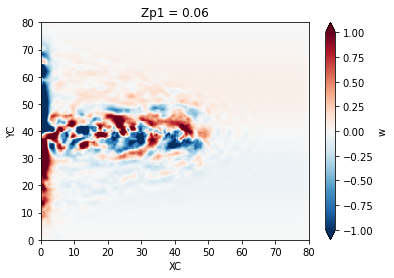

In [7]:
ds = xr.open_zarr(op.join(ddir, 'ctrl/vars000_last187timesteps'))
dsw = xr.open_zarr(op.join(ddir, 'ctrl/W000'))
print(ds)

grid = Grid(ds, periodic=[],
            coords={'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
psib = ds.p.mean('time')
psip = ds.p - psib
up = -grid.diff(psip,'Y',boundary='fill') / dx
vp = grid.diff(psip,'X',boundary='fill') / dx
wb = dsw.w.mean('time')
wp = dsw.w - wb

(wb.isel(Zp1=0)*U*H/Rd*86400).plot(vmax=1.)

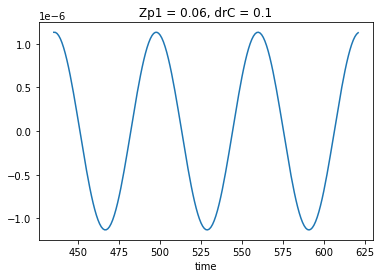

In [8]:
Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                  )
aFrN = xr.DataArray(np.array([0.2,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpm = Frm**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC.isel(Zp1=slice(1,-1))**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [9]:
dpsib_z = -grid.diff(psib,'Z',boundary='fill').isel(Zp1=slice(1,-1))
dpsip_z = -grid.diff(psip,'Z',boundary='fill').isel(Zp1=slice(1,-1))
lapsip = (grid.diff(grid.diff(psip,'X',boundary='fill'),'X',boundary='fill')
          + grid.diff(grid.diff(psip,'Y',boundary='fill'),'Y',boundary='fill')
         ) / dx**2

In [16]:
P_K = 1/Rom * (wb * dpsib_z).sum(['Zp1','YC','XC']).compute() * dx**2

p_k = 1/Rom * (wp * dpsip_z).mean('time').sum(['Zp1','YC','XC']).compute() * dx**2

K_k = (psib * (grid.interp(up,'Y',boundary='fill') 
               * grid.interp(grid.diff(lapsip,'X',boundary='fill'),
                             'X',boundary='fill')
               + grid.interp(vp,'X',boundary='fill') 
               * grid.interp(grid.diff(lapsip,'Y',boundary='fill'),
                             'Y',boundary='fill')
              ).mean('time') / dx * ds.drF 
      ).sum(['Z','YC','XC']).compute() * dx**2
# print(P_K,p_k,K_k)

In [14]:
P_p1 = -((dpsib_z.isel(Zp1=0) * (grid.interp(up.isel(Z=0),'Y',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'X',boundary='fill'),
                                               'X',boundary='fill')
                                 + grid.interp(vp.isel(Z=0),'X',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'Y',boundary='fill'),
                                               'Y',boundary='fill')
                                ).mean('time').data / dx
        ) / gpm.isel(Zp1=0)).sum(['XC','YC']) / Rom**2
P_p3 = -((dpsib_z.isel(Zp1=-1) * (grid.interp(up.isel(Z=-1),'Y',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'X',boundary='fill'),
                                                'X',boundary='fill')
                                  + grid.interp(vp.isel(Z=-1),'X',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'Y',boundary='fill'),
                                                'Y',boundary='fill')
                                 ).mean('time').data / dx
        ) / gpm.isel(Zp1=-1)).sum(['XC','YC']) / Rom**2
P_p = xr.concat([P_p1,P_p3], 'Zp1').sum('Zp1').compute() * dx**2
# P_p

In [17]:
print(P_K, p_k, K_k, P_p)

<xarray.DataArray ()>
array(-5.26808986) <xarray.DataArray ()>
array(-18.89779385) <xarray.DataArray ()>
array(-37.10441558) <xarray.DataArray ()>
array(14.51621776)


In [33]:
client.close()